Asignatura: Tipología y ciclo de vida de los datos.
Alumnos: PABLO CHILLERÓN BEVIÁ y EVGENY MUZAREV GEVORGIAN

Práctica 1.

Esta practica consiste de 2 fases: Fase 1 Scraping y Fase 2 El Análisis. 



# FASE 1 SRAPING.

## Descripción.

Con este script lo que se pretende es, recolectar las ofertas del portal bookings.com de las próximas dos semanas(14 días), a partir del momento de ejecución del script. Los criterios de las ofertas son: país España, actividad Playa, 1 persona adulta sin niños, para una noche. Es decir, el portal bookings.com nos muestra todas las ofertas de hoteles en España, que están situados en zonas costeras, cerca de la playa, para pernoctar una persona sin niños.

La forma en la que se preve recoger y presentar los datos de las ofertas es un dataframe, que contendra las siguientes columnas(variables): ['name','stars','addr','country','city','postal_c','score','comments','beach','service_1','service_2',...'service_n', 'price']

Las ofertas se presentan en forma de bloques, unos 25 bloques por página, que contienen el precio de la oferta y una información breve. Estos bloques contienen urls que llevan a las fichas de ofertas con la información más detallada.

Este script recoge el nombre del hotel de la oferta (la variable 'name'), el nº de estrellas (la variable 'stars'), la dirección completa (la variable 'addr'), el país (la variable 'country'), la ciudad (la variable 'city'), el código postal (la variable 'postal_c'), el rating del hotel entre los usuarios (la variable 'score'), el nº de comentarios sobre hotel (la variable 'comments'), el rating sobre la playa (la variable 'beach'), los servicios que ofrece el hotel, como wifi gratis, parking, piscina, etc. (las variables llevarán el nombre de los servicios), estos servicios se presentarán en forma binaria: 1 el servicio presente en la oferta, 0 no. Finalmente, se recoge el precio de la oferta (la variable 'price'). 

Se prevé que el script recoja un dataframe de unos aproximadamente 15-16 variables, por unos 14000 registros (ofertas), ya que el portal bookings.com muestra unas mil ofertas por fecha.

La lógica del script es la siguiente. Primero, se recogen las urls de todas las ofertas por fechas. Segundo, se extraen todas las variables de cada una de las urls recogidas en el primer paso.

Para esto, se divide el proceso en dos. El primer proceso recolecta las urls de las ofertas, que son aproximadamente 14000 urls, y dura unos 30 minutos. El segundo proceso, que se encarga de la extracción de los datos, puede procesar unas 1000 páginas por hora, si se utiliza de manera secuencial, es decir una url detrás de otra, y unas 1000 urls cada 5 minutos, si se utiliza multi-threading. 

Si no se utiliza multi-threading, se tardaría más de 10 horas en completar el proceso. Utilizando multi-threading, se tarda 2-3 horas, aun así, el proceso completo es <strong>MUY LENTO</strong>.



Para probar la funcionalidad del script, el nº de días está establecido a sólo 1 día, en lugar de 14. Mientras que el dataset utilizado para el análisis, contiene 14 días. Es decir, al ejecutar todo el código, se generará un dataset pequeño de aproximadamente 1000 entradas(depende de la cantidad de ofertas que haya el día que se ejecuta el código) después de completarse la fase de scraping(dataframe.csv), y para la fase del análisis, se utiliza el dataset completo de 14 días, que contiene 13943 registros(dataframe_13943.csv), generado con anterioridad. Todo esto hace que el código tarda unos 7-10 minutos como mucho en ejecutarse completamente. Con lo cual, se puede ejecutarlo sin miedo.

## 1. Extracción de las urls de las ofertas.


La extracción consiste en crear un diccionario, que contendrá todas las urls de todas las ofertas, para cada una de las fechas, empezando desde la fecha en la cual se ejecuta el script + 13 días. El diccionario tendrá la fecha para la que se hace la búsqueda como la clave (key), y una lista de urls para esta fecha como valor(value).

Para esto, creamos una lista de las urls de las páginas de respuesta a la búsqueda para cada una de las fechas. Estas páginas aparte de presentar los bloques con ofertas, también abajo del todo, presentan botones-enlaces a las siguientes páginas, que muestran otros 25 resultados(1,2,3,...n,..9). Las urls de estas páginas son distintas a las urls de las primeras páginas. Con lo cual, es necesario generar un segundo tipo de las urls a partir de la primera, modificándolos un poco y añadiendo la parte de búsqueda que siempre acaba en el número de resultados a mostrar (=25, =50, =75, etc). Abajo de la página, se muestran botones para pasar a la siguiente página (1,2,3....8,9). Sabiendo qué número es el último, sabemos cuantos pasos de 25 hay que dar. Por ejemplo, si el último número de los botones acaba en 7, sabemos que hay que incrementar 7 veces en 25 el último número de la url: =25 (se muestran resultados de 26 a 50), =50 (se muestran resultados de 51 a 75), =75(de 76-100),..., y así hasta 7 veces, 7x25=175. 

De esta manera, pasando por cada una de estas urls que contienen 25 ofertas, extraemos las urls de fichas de estas 25 ofertas. Es decir, primero construimos unas urls, para poder extraer otras.

Estas últimas, se utilizarán ya para extraer los datos.

Aparte de las urls, también se extraen los precios de las ofertas que se muestran en los bloques, ya que no ha sido posible extraerlos en el segundo proceso, por la complejidad de la implementación. Esto es debido a que los parsers que se utilizan en la librería bs4 (html_parser y lxml) son muy caprichosos y procesan html de las páginas de manera distinta. Al igual que pasa con los módulos de la librería requests, depende de cual se utiliza para establecer la conexión, influye, por lo visto, en cómo manda el código html el servidor. Todo esto presenta ciertas dificultades a la hora de implementar el parsing, ya que, primero el código html que el servidor manda al nuestro navegador y el que vemos en el 'Element Inspector' puede no coincidir con el código html que manda el servidor a petición del módulo de la librería 'requests'. Luego, cada parser (html_parser y lxml) procesa el código de manera distinta, hasta el punto que los tags que vemos en el 'Element Inspector', no están presentes en html que tenemos cargado en bs4. Realmente, ha sido bastante complicado ir jugando con los parsers y los módulos de 'request', para encontrar la combinación óptima.

Por ejemplo, para extraer las urls de las fichas de ofertas y los nombres de hoteles, es mejor utilizar css selector, 'html_parser' y requests.get(), mientras que para extraer los datos de las ofertas, es mejor utilizar
'lxml' parser y urllib.request.urlopen().


In [1]:
# Cargamos librerías necesarias

import requests
from bs4 import BeautifulSoup
from datetime import timedelta
import time
import datetime as datetime
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import urllib.request
import lxml
import pickle
headers = {"User-Agent":"Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/5"\
           "37.36 (KHTML, like Gecko) Chrome/94.0.4606.81 Safari/537.36"}
import warnings
warnings.filterwarnings('ignore')


/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


### La función url_l_f(), que compone la urls de las páginas de resultados.

Esta función es la que compone las urls de las páginas de los resultados de las ofertas, y que pasa estas urls a la siguiente función baige(), encargada de extraer las urls de las fichas de las ofertas y los precios.

In [2]:
def url_l_f(url,pags):
    
    ##### Esta función recibe de 2 argumentos: la url inicial de los resultados    #####
    ##### con las fichas de los hoteles, que servirá de base a partir de la cual   #####
    ##### se van a construir las siguientes url'es consecutivas de la muestra de   #####
    ##### los resultados(25,50,75,100,125,...,pags) y el número de páginas(pags)   #####
    ##### de 25 resultados cada una, hasta que hay que contruir las URLs           ##### 
    ##### Finalmente, la función pasa cada una de las url'es generadas a la        #####
    ##### baige(), que se encarga de extraer cada una de las url de las fichas de  #####
    ##### hoteles, y sus precio y el nombre.                                       #####
    
    # Iniciamos el número de resultados a mostrar con un 0
    b = 0
    # Para cada una de las páginas
    for i in range(0,pags):
        # Incrementamos un paso(cada paso=página de 25 resultados)
        b = b+25
        # Añadimos el paso a la url base y la pasamos a la función baige()
        baige(url+str(b),0)
        


### La función baige(), que extrae las urls de las fichas de ofertas y precios.

Esta función recibe las urls procedentes de la función anterior url_l_f(), una a una, realiza una conexión 'request' al bookikgs.com y extrae las urls de las fichas de las ofertas y sus precios. Las urls, cada una con su identificador, se agregan a un diccionario directamente, igual que los precios y los nombres, cada uno con su identificador, se agregan en dos diccionarios separados. Los identificadores se utilizan para poder recrear el orden original de los registros, debido a que el orden se altera al utilizar multi-threading, y el orden original lo necesitamos para unir correctamente los precios al dataframe.

El motivo por el cual se extrae el precio en esta parte del proceso y no junto con el resto de los datos, ya se ha expuesto mas arriba, y es que extraer el precio desde los bloques de ofertas de la página de resultados es más fácil que desde las fichas, que son casi imposibles de acceder.



In [3]:
def baige(url, x):
    
    ##### Esta función recibe una url de la página que contiene las fichas de      #####
    ##### hoteles que salen en los resultados de la búsqueda, realiza una llamada  #####
    ##### al servidor con la url pasada utilizando la librería requests, crea un   #####
    ##### objeto 's' de bs4 con la sesión y el parser, scrapea las url'es de cada  #####
    ##### una de las fichas de los hoteles que salen en la página y los agrega a   #####
    ##### la lista ls[]. También devuelve las el objeto 's' con la sesión, y       #####
    ##### también imprime por pantalla las urls que va agregando y el contador.    #####
    
    ##### Otra funcionalidad que ha sido añadida posteriormente, es recoger los    #####
    ##### precios y nombres de los hoteles. 
    
    # La llamada al servidor y el objeto 's'
    r = requests.get(url, headers=headers)
    s = BeautifulSoup(r.content, 'lxml')
    
    # El contador
    global d
    # Los identificadores
    global id_u # de url
    global id_p # de precio
    global id_d # de fecha
    
    
    # Accedemos a los elementos de las fichas que contienen partes de url y
    # recreamos url completa
    for f in s.select(".f0b5ba03dc"):
        
        # Imprimimos url por pantalla
        print(f.a['href'].strip())
        
        # Imprimimos e incrementamos el contador
        print(d)
        d=d+1
        
        # Agregamos url al diccionario con su correspondiente id_u
        dic_u[id_u]= f.a['href'].strip()
        # Incrementamos identificador de url
        id_u=id_u+1
        # Agregamos la fecha al diccionario con su correspondiente id_d
        dic_d[id_d] = date
        # Incrementamos id_d 
        id_d=id_d+1
    # Accedemos al precio, lo imprimimos por pantalla y lo agregamos 
    # al diccionario con su correspondiente id_p
    for t in s.select('._e885fdc12'):
        print(t.text.split('€')[1].strip())
        dic_p[id_p] = t.text.split('€')[1].strip()
        id_p=id_p+1
    
    # Por si acaso, controlamos sincronización
    if not((id_u==id_p)&(id_p==id_d)):
        # Si pasa algo, agregamos el nº de id en el cual ha pasado algo
        alarm.append(id_u)
        alarm.append(id_n)
        alarm.append(id_p)
        alarm.append(id_d)
    # Devolvemos la sesión
    if x==1:
        return(s)
    else:
        print("ok")


### El script que arranca la primera parte del proceso, la extracción de urls.

Primero se crea una lista de fechas, luego se componen las correspondientes urls para esta fechas y se van pasando, una a una a la función baige(), la cual descarga el contenido de la primera página de los resultados de la búsqueda, extrae la url y el precio del hotel, y los guarda en los diccionarios.

También devuelve la sesión 's' de bs4 con la primera página cargada, para calcular el número de las páginas de resultados.

A continuación, se llama a la función url_l_f(), pasándole las url de las siguientes páginas de resultados, a las cuales se les añade 25,50,75,100,..., hasta el número de las páginas, que se pasan como el segundo argumento. Esta función pasa las urls obtenidas a la función baige(), que extrae las urls de las fichas y los precios.

Finalmente, se agregan las urls y precios extraídos a sus respectivos diccionarios.

In [4]:
# Busca los próximos días como fechas
prox_dias = 1 # Está puesto a 1 día, para que la ejecución no tarde demasiado, 
              # aunque para generar el dataset para el análisis, se ha utilizado los 14 días
dates = [datetime.date.today() + timedelta(days=j) for j in range(0,prox_dias)]

# Se crea una lista de url'es, por si acaso
urls=[]
# Se crea una especie de controlador para controlar la sincronización de
# extracción de los datos
alarm = []
# Se crea un contador
d=1
# Se crean identificadores para la extracción de urls, precios y fechas
id_u=0
id_p=0
id_d=0

# Creamos el diccionario para las urls{id_u:url} 
dic_u = {}
# Creamos diccionario de precios{id_p:precio}
dic_p = {}
# Creamos el diccionario para fechas{id_p:date}
dic_d = {}

# Para cada una de las fechas:
for date in dates:
    # Creamos una lista en la que se van a agregar los valores
    ls = []
    
    # Extraemos componentes de las fechas de entrada/salida:      
    checkin_date = date  
    checkout_date = date + timedelta(days=1) 
    checkin_day = checkin_date.day
    checkin_month = checkin_date.month
    checkin_year = checkin_date.year
    checkout_day = checkout_date.day
    checkout_month = checkout_date.month
    checkout_year = checkout_date.year
    
    # Recreamos url de la primera página de resultados de la búsqueda  
    url_2 = 'https://www.booking.com/searchresults.es.html?aid=309654&label='\
    'booking-be-es-4hlnAGESyHVwkqBgv3aKIwS479808260559%3Apl%3Ata%3Ap1%3Ap22.563.000%3Aac%3Aap%3Aneg'\
    '%3Afi%3Atikwd-13273066%3Alp1005413%3Ali%3Adec%3Adm%3Appccp%3DUmFuZG9tSVYkc2RlIyh9YcsZ-Id2vkzIfTm'\
    'YhvC5HOg&sid=c4b3f6f420352b7e6268dbe166abff7d&tmpl=searchresults&ac_click_type=b&ac_position=0&'\
    'checkin_month='+str(checkin_date.month)+'&checkin_monthday='+str(checkin_date.day)+'&'\
    'checkin_year='+str(checkin_date.year)+'&checkout_month='+str(checkout_date.month)+'&'\
    'checkout_monthday='+str(checkout_date.day)+'&checkout_year='+str(checkout_date.year)+'&'\
    'city=-373226&class_interval=1&dest_id=197&dest_type=country&from_sf=1&g'\
    'roup_adults=1&group_children=0&label_click=undef&no_rooms=1&raw_dest_type=country&room1=A&'\
    'sb_price_type=total&search_selected=1&shw_aparth=1&slp_r_match=0&src=searchresults&srpvid='\
    '2cc557b3d2e20074&ss=Espa%C3%B1a&ss_raw=Esp&ssb=empty&ssne=Benidorm&ssne_untouched=Benidorm&top_ufis=1&'\
    'sig=v1RzUHRY77&nflt=popular_activities%3D302%3Bht_id%3D204%3B&percent_htype_hotel=1&rsf='
    
    # Recreamos el segundo tipo de url de las páginas de resultados(las que muestran 
    #1-25, 26-50,51-75,...,etc), primera parte
    a = 'https://www.booking.com/searchresults.es.html?aid=309654&label='\
    'booking-be-es-4hlnAGESyHVwkqBgv3aKIwS479808260559%3Apl%3Ata%3Ap1%3Ap22.563.000%3Aac%3Aap%3Aneg'\
    '%3Afi%3Atikwd-13273066%3Alp1005413%3Ali%3Adec%3Adm%3Appccp%3DUmFuZG9tSVYkc2RlIyh9YcsZ-Id2vkzIfTm'\
    'YhvC5HOg&sid=c4b3f6f420352b7e6268dbe166abff7d&tmpl=searchresults&ac_click_type=b&ac_position=0&'\
    'checkin_month='+str(checkin_date.month)+'&checkin_monthday='+str(checkin_date.day)+'&'\
    'checkin_year='+str(checkin_date.year)+'&checkout_month='+str(checkout_date.month)+'&'\
    'checkout_monthday='+str(checkout_date.day)+'&'\
    'checkout_year='+str(checkout_date.year)+'&city=-373226&class_interval=1&dest_id=197&dest_type=country&'
    
    # Segunda parte
    b = 'dtdisc=0&from_sf=1&group_adults=1&group_children=0&inac=0&index_postcard=0&label_click=undef&'\
    'nflt=popular_activities%3D302%3Bht_id%3D204%3B&no_rooms=1&percent_htype_hotel=1&postcard=0&'\
    'raw_dest_type=country&room1=A&sb_price_type=total&search_selected=1&shw_aparth=1&slp_r_match=0&'\
    'src=searchresults&srpvid=65e56cb746a10078&ss=Espa%C3%B1a&ss_all=0&ss_raw=Esp&ssb=empty&sshis=0&'\
    'ssne=Benidorm&ssne_untouched=Benidorm&top_ufis=1&sig=v1hAlQhinU&rows=25&offset='
    
    # Juntamos las dos partes y tenemos una urla inicial, a la cual vamos a ir
    # añadiendo los resultados(25,50,75,100,...) que se mostrarán en la página.
    # 25 resultados por página.
    p_url = a+b
    
    #urls.append(url_2)
    
    # Añadimos el primer valor a la lista, que será la fecha
    ls.append(date)
    

    
    # Llamamos la función baige() que extrae url de las fichas de los hoteles que se muestran en
    # la página de resultados y los guarda en una lista. La función también devuelve s(un objeto 
    # de bs4 con la primera página de resultados de la búsqueda para cada fecha)
    s=baige(url_2,1)
    
    ### Cálculo de nº de páginas de resultados: Nºres.devueltos/25 = nºde páginas ###
    
    # Accedemos al elemento de la página, que muestra el número de resultados de la búsqueda y 
    # si devuelve más de 1000 resultados, por ejemplo 1346, lo dejamos a 1000, ya que el servidor
    # de booking no muestra más de 1000 resultados, que son 40 páginas de 25 resultados en cada una
    if '.' in s.find('div',{'id':'bodyconstraint'}).div.find('div',{'id':'searchresultsTmpl'}).div.div.h1.text.split(' ')[1].strip():
        pags = 39
    # Si la búsqueda devuelve menos de 1000 resultados, se deviden entre 25, se redondea
    # al número mayor siguiente, si la división devuelve decimales
    else:
        v = int(s.find('div',{'id':'bodyconstraint'}).div.find('div',{'id':'searchresultsTmpl'}).div.div.h1.text.split(' ')[1].strip())
        pags = int(v/25) + (v%25 > 0)
    
    
    # Se llama la función url_l_f(), a la que se le pasa la p_url, url que se ha preparado
    # anteriormente, que es la url inicial de todas las páginas de resultados, que acaba en
    # "https://www.booking.com/../..offset=", y a la que se le va añadiendo offset=25,
    # offset=50, offset=75, offset=100, etcétera, en función del número de páginas(pags).
    # Luego, se guarda la url de cada una de las fichas de hoteles que se muestran en
    # la página, unas 25, y se van añadiendo a la lista ls[].
    url_l_f(p_url,pags)
    
    # Finalmente, guardamos la lista ls[] en el diccionario que hemos creado anteriormente.
    # Para cada fecha(que son 14), guardaremos la lista ls[], con sus correspondientes 
    # url'es, que hemos recogido con las funciones baige()(para recoger url's de primera
    # página) y url_l_f(), para recoger url'es del resto de la página, para cada una de
    # las 14 fechas. 
    #dic[date]=ls

        

https://www.booking.com/hotel/es/ocean-drive.es.html?label=booking-be-es-4hlnAGESyHVwkqBgv3aKIwS479808260559%3Apl%3Ata%3Ap1%3Ap22.563.000%3Aac%3Aap%3Aneg%3Afi%3Atikwd-13273066%3Alp1005413%3Ali%3Adec%3Adm%3Appccp%3DUmFuZG9tSVYkc2RlIyh9YcsZ-Id2vkzIfTmYhvC5HOg&sid=c4b3f6f420352b7e6268dbe166abff7d&aid=309654&ucfs=1&arphpl=1&checkin=2021-11-02&checkout=2021-11-03&dest_id=197&dest_type=country&group_adults=1&req_adults=1&no_rooms=1&group_children=0&req_children=0&hpos=0&hapos=0&sr_order=popularity&nflt=popular_activities%3D302%3Bht_id%3D204&srpvid=e5889d97535a014d&srepoch=1635891888&all_sr_blocks=9385511_288853738_0_2_0&highlighted_blocks=9385511_288853738_0_2_0&matching_block_id=9385511_288853738_0_2_0&sr_pri_blocks=9385511_288853738_0_2_0__7828&from=searchresults#hotelTmpl
1
https://www.booking.com/hotel/es/marbellaelfaro.es.html?label=booking-be-es-4hlnAGESyHVwkqBgv3aKIwS479808260559%3Apl%3Ata%3Ap1%3Ap22.563.000%3Aac%3Aap%3Aneg%3Afi%3Atikwd-13273066%3Alp1005413%3Ali%3Adec%3Adm%3Appccp%3DU

https://www.booking.com/hotel/es/palacio-munatones.es.html?label=booking-be-es-4hlnAGESyHVwkqBgv3aKIwS479808260559%3Apl%3Ata%3Ap1%3Ap22.563.000%3Aac%3Aap%3Aneg%3Afi%3Atikwd-13273066%3Alp1005413%3Ali%3Adec%3Adm%3Appccp%3DUmFuZG9tSVYkc2RlIyh9YcsZ-Id2vkzIfTmYhvC5HOg&sid=c4b3f6f420352b7e6268dbe166abff7d&aid=309654&ucfs=1&arphpl=1&checkin=2021-11-02&checkout=2021-11-03&dest_id=197&dest_type=country&group_adults=1&req_adults=1&no_rooms=1&group_children=0&req_children=0&hpos=0&hapos=25&sr_order=popularity&nflt=popular_activities%3D302%3Bht_id%3D204&srpvid=0ddb9d98f8b10075&srepoch=1635891890&all_sr_blocks=9775703_90636931_0_2_0&highlighted_blocks=9775703_90636931_0_2_0&matching_block_id=9775703_90636931_0_2_0&sr_pri_blocks=9775703_90636931_0_2_0__7300&from=searchresults#hotelTmpl
26
https://www.booking.com/hotel/es/el-hostal-del-cubo.es.html?label=booking-be-es-4hlnAGESyHVwkqBgv3aKIwS479808260559%3Apl%3Ata%3Ap1%3Ap22.563.000%3Aac%3Aap%3Aneg%3Afi%3Atikwd-13273066%3Alp1005413%3Ali%3Adec%3Adm%3Ap

https://www.booking.com/hotel/es/los-jameos-playa.es.html?label=booking-be-es-4hlnAGESyHVwkqBgv3aKIwS479808260559%3Apl%3Ata%3Ap1%3Ap22.563.000%3Aac%3Aap%3Aneg%3Afi%3Atikwd-13273066%3Alp1005413%3Ali%3Adec%3Adm%3Appccp%3DUmFuZG9tSVYkc2RlIyh9YcsZ-Id2vkzIfTmYhvC5HOg&sid=c4b3f6f420352b7e6268dbe166abff7d&aid=309654&ucfs=1&arphpl=1&checkin=2021-11-02&checkout=2021-11-03&dest_id=197&dest_type=country&group_adults=1&req_adults=1&no_rooms=1&group_children=0&req_children=0&hpos=0&hapos=50&sr_order=popularity&nflt=popular_activities%3D302%3Bht_id%3D204&srpvid=af489d99e77f0062&srepoch=1635891893&all_sr_blocks=2549212_335295048_0_1_0&highlighted_blocks=2549212_335295048_0_1_0&matching_block_id=2549212_335295048_0_1_0&sr_pri_blocks=2549212_335295048_0_1_0__18900&from=searchresults#hotelTmpl
51
https://www.booking.com/hotel/es/caprici-verd.es.html?label=booking-be-es-4hlnAGESyHVwkqBgv3aKIwS479808260559%3Apl%3Ata%3Ap1%3Ap22.563.000%3Aac%3Aap%3Aneg%3Afi%3Atikwd-13273066%3Alp1005413%3Ali%3Adec%3Adm%3Appc

https://www.booking.com/hotel/es/hotelmarconi.es.html?label=booking-be-es-4hlnAGESyHVwkqBgv3aKIwS479808260559%3Apl%3Ata%3Ap1%3Ap22.563.000%3Aac%3Aap%3Aneg%3Afi%3Atikwd-13273066%3Alp1005413%3Ali%3Adec%3Adm%3Appccp%3DUmFuZG9tSVYkc2RlIyh9YcsZ-Id2vkzIfTmYhvC5HOg&sid=c4b3f6f420352b7e6268dbe166abff7d&aid=309654&ucfs=1&arphpl=1&checkin=2021-11-02&checkout=2021-11-03&dest_id=197&dest_type=country&group_adults=1&req_adults=1&no_rooms=1&group_children=0&req_children=0&hpos=0&hapos=75&sr_order=popularity&nflt=popular_activities%3D302%3Bht_id%3D204&srpvid=9d4c9d9a452c012d&srepoch=1635891895&all_sr_blocks=54745_331836503_0_41_0&highlighted_blocks=54745_331836503_0_41_0&matching_block_id=54745_331836503_0_41_0&sr_pri_blocks=54745_331836503_0_41_0__3500&from=searchresults#hotelTmpl
76
https://www.booking.com/hotel/es/confortel-caleta-park.es.html?label=booking-be-es-4hlnAGESyHVwkqBgv3aKIwS479808260559%3Apl%3Ata%3Ap1%3Ap22.563.000%3Aac%3Aap%3Aneg%3Afi%3Atikwd-13273066%3Alp1005413%3Ali%3Adec%3Adm%3Appc

https://www.booking.com/hotel/es/castillo-suites.es.html?label=booking-be-es-4hlnAGESyHVwkqBgv3aKIwS479808260559%3Apl%3Ata%3Ap1%3Ap22.563.000%3Aac%3Aap%3Aneg%3Afi%3Atikwd-13273066%3Alp1005413%3Ali%3Adec%3Adm%3Appccp%3DUmFuZG9tSVYkc2RlIyh9YcsZ-Id2vkzIfTmYhvC5HOg&sid=c4b3f6f420352b7e6268dbe166abff7d&aid=309654&ucfs=1&arphpl=1&checkin=2021-11-02&checkout=2021-11-03&dest_id=197&dest_type=country&group_adults=1&req_adults=1&no_rooms=1&group_children=0&req_children=0&hpos=0&hapos=100&sr_order=popularity&nflt=popular_activities%3D302%3Bht_id%3D204&srpvid=a9139d9c6b8000e8&srepoch=1635891897&all_sr_blocks=46919602_86109101_0_17_0&highlighted_blocks=46919602_86109101_0_17_0&matching_block_id=46919602_86109101_0_17_0&sr_pri_blocks=46919602_86109101_0_17_0__19370&from=searchresults#hotelTmpl
101
https://www.booking.com/hotel/es/roca-esmeralda-spa.es.html?label=booking-be-es-4hlnAGESyHVwkqBgv3aKIwS479808260559%3Apl%3Ata%3Ap1%3Ap22.563.000%3Aac%3Aap%3Aneg%3Afi%3Atikwd-13273066%3Alp1005413%3Ali%3Adec

https://www.booking.com/hotel/es/medplaya-riviera.es.html?label=booking-be-es-4hlnAGESyHVwkqBgv3aKIwS479808260559%3Apl%3Ata%3Ap1%3Ap22.563.000%3Aac%3Aap%3Aneg%3Afi%3Atikwd-13273066%3Alp1005413%3Ali%3Adec%3Adm%3Appccp%3DUmFuZG9tSVYkc2RlIyh9YcsZ-Id2vkzIfTmYhvC5HOg&sid=c4b3f6f420352b7e6268dbe166abff7d&aid=309654&ucfs=1&arphpl=1&checkin=2021-11-02&checkout=2021-11-03&dest_id=197&dest_type=country&group_adults=1&req_adults=1&no_rooms=1&group_children=0&req_children=0&hpos=0&hapos=125&sr_order=popularity&nflt=popular_activities%3D302%3Bht_id%3D204&srpvid=46c79d9d54ad0070&srepoch=1635891899&all_sr_blocks=9366004_298935754_0_0_0&highlighted_blocks=9366004_298935754_0_0_0&matching_block_id=9366004_298935754_0_0_0&sr_pri_blocks=9366004_298935754_0_0_0__8010&from=searchresults#hotelTmpl
126
https://www.booking.com/hotel/es/exotix.es.html?label=booking-be-es-4hlnAGESyHVwkqBgv3aKIwS479808260559%3Apl%3Ata%3Ap1%3Ap22.563.000%3Aac%3Aap%3Aneg%3Afi%3Atikwd-13273066%3Alp1005413%3Ali%3Adec%3Adm%3Appccp%3D

https://www.booking.com/hotel/es/adiafa.es.html?label=booking-be-es-4hlnAGESyHVwkqBgv3aKIwS479808260559%3Apl%3Ata%3Ap1%3Ap22.563.000%3Aac%3Aap%3Aneg%3Afi%3Atikwd-13273066%3Alp1005413%3Ali%3Adec%3Adm%3Appccp%3DUmFuZG9tSVYkc2RlIyh9YcsZ-Id2vkzIfTmYhvC5HOg&sid=c4b3f6f420352b7e6268dbe166abff7d&aid=309654&ucfs=1&arphpl=1&checkin=2021-11-02&checkout=2021-11-03&dest_id=197&dest_type=country&group_adults=1&req_adults=1&no_rooms=1&group_children=0&req_children=0&hpos=0&hapos=150&sr_order=popularity&nflt=popular_activities%3D302%3Bht_id%3D204&srpvid=0eba9d9eba59002a&srepoch=1635891901&all_sr_blocks=9384301_134282896_0_2_0&highlighted_blocks=9384301_134282896_0_2_0&matching_block_id=9384301_134282896_0_2_0&sr_pri_blocks=9384301_134282896_0_2_0__5900&from=searchresults#hotelTmpl
151
https://www.booking.com/hotel/es/riu-vistamar-all-inclusive.es.html?label=booking-be-es-4hlnAGESyHVwkqBgv3aKIwS479808260559%3Apl%3Ata%3Ap1%3Ap22.563.000%3Aac%3Aap%3Aneg%3Afi%3Atikwd-13273066%3Alp1005413%3Ali%3Adec%3Adm%

https://www.booking.com/hotel/es/medes-ii.es.html?label=booking-be-es-4hlnAGESyHVwkqBgv3aKIwS479808260559%3Apl%3Ata%3Ap1%3Ap22.563.000%3Aac%3Aap%3Aneg%3Afi%3Atikwd-13273066%3Alp1005413%3Ali%3Adec%3Adm%3Appccp%3DUmFuZG9tSVYkc2RlIyh9YcsZ-Id2vkzIfTmYhvC5HOg&sid=c4b3f6f420352b7e6268dbe166abff7d&aid=309654&ucfs=1&arphpl=1&checkin=2021-11-02&checkout=2021-11-03&dest_id=197&dest_type=country&group_adults=1&req_adults=1&no_rooms=1&group_children=0&req_children=0&hpos=0&hapos=175&sr_order=popularity&nflt=popular_activities%3D302%3Bht_id%3D204&srpvid=ca849d9fd50100a6&srepoch=1635891904&all_sr_blocks=9424701_272501274_0_42_0&highlighted_blocks=9424701_272501274_0_42_0&matching_block_id=9424701_272501274_0_42_0&sr_pri_blocks=9424701_272501274_0_42_0__8066&from=searchresults#hotelTmpl
176
https://www.booking.com/hotel/es/royal-sunset-beach-club.es.html?label=booking-be-es-4hlnAGESyHVwkqBgv3aKIwS479808260559%3Apl%3Ata%3Ap1%3Ap22.563.000%3Aac%3Aap%3Aneg%3Afi%3Atikwd-13273066%3Alp1005413%3Ali%3Adec%3A

https://www.booking.com/hotel/es/costa-ballena-beach-golf-thalasso-convention.es.html?label=booking-be-es-4hlnAGESyHVwkqBgv3aKIwS479808260559%3Apl%3Ata%3Ap1%3Ap22.563.000%3Aac%3Aap%3Aneg%3Afi%3Atikwd-13273066%3Alp1005413%3Ali%3Adec%3Adm%3Appccp%3DUmFuZG9tSVYkc2RlIyh9YcsZ-Id2vkzIfTmYhvC5HOg&sid=c4b3f6f420352b7e6268dbe166abff7d&aid=309654&ucfs=1&arphpl=1&checkin=2021-11-02&checkout=2021-11-03&dest_id=197&dest_type=country&group_adults=1&req_adults=1&no_rooms=1&group_children=0&req_children=0&hpos=0&hapos=200&sr_order=popularity&nflt=popular_activities%3D302%3Bht_id%3D204&srpvid=fa459da025ea0073&srepoch=1635891906&all_sr_blocks=1206126_224878089_0_1_0&highlighted_blocks=1206126_224878089_0_1_0&matching_block_id=1206126_224878089_0_1_0&sr_pri_blocks=1206126_224878089_0_1_0__7050&from=searchresults#hotelTmpl
201
https://www.booking.com/hotel/es/front-maritim.es.html?label=booking-be-es-4hlnAGESyHVwkqBgv3aKIwS479808260559%3Apl%3Ata%3Ap1%3Ap22.563.000%3Aac%3Aap%3Aneg%3Afi%3Atikwd-13273066%3Al

https://www.booking.com/hotel/es/granuadalpinbanusmarbella.es.html?label=booking-be-es-4hlnAGESyHVwkqBgv3aKIwS479808260559%3Apl%3Ata%3Ap1%3Ap22.563.000%3Aac%3Aap%3Aneg%3Afi%3Atikwd-13273066%3Alp1005413%3Ali%3Adec%3Adm%3Appccp%3DUmFuZG9tSVYkc2RlIyh9YcsZ-Id2vkzIfTmYhvC5HOg&sid=c4b3f6f420352b7e6268dbe166abff7d&aid=309654&ucfs=1&arphpl=1&checkin=2021-11-02&checkout=2021-11-03&dest_id=197&dest_type=country&group_adults=1&req_adults=1&no_rooms=1&group_children=0&req_children=0&hpos=0&hapos=225&sr_order=popularity&nflt=popular_activities%3D302%3Bht_id%3D204&srpvid=e86a9da13b950054&srepoch=1635891909&all_sr_blocks=9161627_90430921_0_1_0&highlighted_blocks=9161627_90430921_0_1_0&matching_block_id=9161627_90430921_0_1_0&sr_pri_blocks=9161627_90430921_0_1_0__15800&from=searchresults#hotelTmpl
226
https://www.booking.com/hotel/es/husarogerdeflor.es.html?label=booking-be-es-4hlnAGESyHVwkqBgv3aKIwS479808260559%3Apl%3Ata%3Ap1%3Ap22.563.000%3Aac%3Aap%3Aneg%3Afi%3Atikwd-13273066%3Alp1005413%3Ali%3Adec%

https://www.booking.com/hotel/es/sol-marbella-estepona-atalaya-park.es.html?label=booking-be-es-4hlnAGESyHVwkqBgv3aKIwS479808260559%3Apl%3Ata%3Ap1%3Ap22.563.000%3Aac%3Aap%3Aneg%3Afi%3Atikwd-13273066%3Alp1005413%3Ali%3Adec%3Adm%3Appccp%3DUmFuZG9tSVYkc2RlIyh9YcsZ-Id2vkzIfTmYhvC5HOg&sid=c4b3f6f420352b7e6268dbe166abff7d&aid=309654&ucfs=1&arphpl=1&checkin=2021-11-02&checkout=2021-11-03&dest_id=197&dest_type=country&group_adults=1&req_adults=1&no_rooms=1&group_children=0&req_children=0&hpos=0&hapos=250&sr_order=popularity&nflt=popular_activities%3D302%3Bht_id%3D204&srpvid=98139da2b189015f&srepoch=1635891911&all_sr_blocks=9174125_332154030_1_1_0&highlighted_blocks=9174125_332154030_1_1_0&matching_block_id=9174125_332154030_1_1_0&sr_pri_blocks=9174125_332154030_1_1_0__8000&from=searchresults#hotelTmpl
251
https://www.booking.com/hotel/es/trias.es.html?label=booking-be-es-4hlnAGESyHVwkqBgv3aKIwS479808260559%3Apl%3Ata%3Ap1%3Ap22.563.000%3Aac%3Aap%3Aneg%3Afi%3Atikwd-13273066%3Alp1005413%3Ali%3Ade

https://www.booking.com/hotel/es/parador-la-muralla.es.html?label=booking-be-es-4hlnAGESyHVwkqBgv3aKIwS479808260559%3Apl%3Ata%3Ap1%3Ap22.563.000%3Aac%3Aap%3Aneg%3Afi%3Atikwd-13273066%3Alp1005413%3Ali%3Adec%3Adm%3Appccp%3DUmFuZG9tSVYkc2RlIyh9YcsZ-Id2vkzIfTmYhvC5HOg&sid=c4b3f6f420352b7e6268dbe166abff7d&aid=309654&ucfs=1&arphpl=1&checkin=2021-11-02&checkout=2021-11-03&dest_id=197&dest_type=country&group_adults=1&req_adults=1&no_rooms=1&group_children=0&req_children=0&hpos=0&hapos=275&sr_order=popularity&nflt=popular_activities%3D302%3Bht_id%3D204&srpvid=661c9da3650f0018&srepoch=1635891913&all_sr_blocks=1749601_229502198_0_42_0&highlighted_blocks=1749601_229502198_0_42_0&matching_block_id=1749601_229502198_0_42_0&sr_pri_blocks=1749601_229502198_0_42_0__8000&from=searchresults#hotelTmpl
276
https://www.booking.com/hotel/es/royal-andalus.es.html?label=booking-be-es-4hlnAGESyHVwkqBgv3aKIwS479808260559%3Apl%3Ata%3Ap1%3Ap22.563.000%3Aac%3Aap%3Aneg%3Afi%3Atikwd-13273066%3Alp1005413%3Ali%3Adec%3A

https://www.booking.com/hotel/es/nuria.es.html?label=booking-be-es-4hlnAGESyHVwkqBgv3aKIwS479808260559%3Apl%3Ata%3Ap1%3Ap22.563.000%3Aac%3Aap%3Aneg%3Afi%3Atikwd-13273066%3Alp1005413%3Ali%3Adec%3Adm%3Appccp%3DUmFuZG9tSVYkc2RlIyh9YcsZ-Id2vkzIfTmYhvC5HOg&sid=c4b3f6f420352b7e6268dbe166abff7d&aid=309654&ucfs=1&arphpl=1&checkin=2021-11-02&checkout=2021-11-03&dest_id=197&dest_type=country&group_adults=1&req_adults=1&no_rooms=1&group_children=0&req_children=0&hpos=0&hapos=300&sr_order=popularity&nflt=popular_activities%3D302%3Bht_id%3D204&srpvid=a11c9da552e90083&srepoch=1635891916&all_sr_blocks=9093402_130795778_1_2_0&highlighted_blocks=9093402_130795778_1_2_0&matching_block_id=9093402_130795778_1_2_0&sr_pri_blocks=9093402_130795778_1_2_0__7233&from=searchresults#hotelTmpl
301
https://www.booking.com/hotel/es/parador-la-muralla.es.html?label=booking-be-es-4hlnAGESyHVwkqBgv3aKIwS479808260559%3Apl%3Ata%3Ap1%3Ap22.563.000%3Aac%3Aap%3Aneg%3Afi%3Atikwd-13273066%3Alp1005413%3Ali%3Adec%3Adm%3Appccp%3

https://www.booking.com/hotel/es/mare-nostrum.es.html?label=booking-be-es-4hlnAGESyHVwkqBgv3aKIwS479808260559%3Apl%3Ata%3Ap1%3Ap22.563.000%3Aac%3Aap%3Aneg%3Afi%3Atikwd-13273066%3Alp1005413%3Ali%3Adec%3Adm%3Appccp%3DUmFuZG9tSVYkc2RlIyh9YcsZ-Id2vkzIfTmYhvC5HOg&sid=c4b3f6f420352b7e6268dbe166abff7d&aid=309654&ucfs=1&arphpl=1&checkin=2021-11-02&checkout=2021-11-03&dest_id=197&dest_type=country&group_adults=1&req_adults=1&no_rooms=1&group_children=0&req_children=0&hpos=0&hapos=325&sr_order=popularity&nflt=popular_activities%3D302%3Bht_id%3D204&srpvid=44969da6cf4c0012&srepoch=1635891918&all_sr_blocks=1784701_188426967_0_33_0&highlighted_blocks=1784701_188426967_0_33_0&matching_block_id=1784701_188426967_0_33_0&sr_pri_blocks=1784701_188426967_0_33_0__24610&from=searchresults#hotelTmpl
326
https://www.booking.com/hotel/es/sol-principe.es.html?label=booking-be-es-4hlnAGESyHVwkqBgv3aKIwS479808260559%3Apl%3Ata%3Ap1%3Ap22.563.000%3Aac%3Aap%3Aneg%3Afi%3Atikwd-13273066%3Alp1005413%3Ali%3Adec%3Adm%3Ap

https://www.booking.com/hotel/es/gijon.es.html?label=booking-be-es-4hlnAGESyHVwkqBgv3aKIwS479808260559%3Apl%3Ata%3Ap1%3Ap22.563.000%3Aac%3Aap%3Aneg%3Afi%3Atikwd-13273066%3Alp1005413%3Ali%3Adec%3Adm%3Appccp%3DUmFuZG9tSVYkc2RlIyh9YcsZ-Id2vkzIfTmYhvC5HOg&sid=c4b3f6f420352b7e6268dbe166abff7d&aid=309654&ucfs=1&arphpl=1&checkin=2021-11-02&checkout=2021-11-03&dest_id=197&dest_type=country&group_adults=1&req_adults=1&no_rooms=1&group_children=0&req_children=0&hpos=0&hapos=350&sr_order=popularity&nflt=popular_activities%3D302%3Bht_id%3D204&srpvid=2a549da77d640089&srepoch=1635891921&all_sr_blocks=4769602_93698638_0_0_0&highlighted_blocks=4769602_93698638_0_0_0&matching_block_id=4769602_93698638_0_0_0&sr_pri_blocks=4769602_93698638_0_0_0__10300&from=searchresults#hotelTmpl
351
https://www.booking.com/hotel/es/pez-espada.es.html?label=booking-be-es-4hlnAGESyHVwkqBgv3aKIwS479808260559%3Apl%3Ata%3Ap1%3Ap22.563.000%3Aac%3Aap%3Aneg%3Afi%3Atikwd-13273066%3Alp1005413%3Ali%3Adec%3Adm%3Appccp%3DUmFuZG9tSV

https://www.booking.com/hotel/es/oasis-by-don-carlos-resort.es.html?label=booking-be-es-4hlnAGESyHVwkqBgv3aKIwS479808260559%3Apl%3Ata%3Ap1%3Ap22.563.000%3Aac%3Aap%3Aneg%3Afi%3Atikwd-13273066%3Alp1005413%3Ali%3Adec%3Adm%3Appccp%3DUmFuZG9tSVYkc2RlIyh9YcsZ-Id2vkzIfTmYhvC5HOg&sid=c4b3f6f420352b7e6268dbe166abff7d&aid=309654&ucfs=1&arphpl=1&checkin=2021-11-02&checkout=2021-11-03&dest_id=197&dest_type=country&group_adults=1&req_adults=1&no_rooms=1&group_children=0&req_children=0&hpos=0&hapos=375&sr_order=popularity&nflt=popular_activities%3D302%3Bht_id%3D204&srpvid=c5ec9da8ee38011e&srepoch=1635891923&all_sr_blocks=90070601_237341901_0_41_0&highlighted_blocks=90070601_237341901_0_41_0&matching_block_id=90070601_237341901_0_41_0&sr_pri_blocks=90070601_237341901_0_41_0__47850&from=searchresults#hotelTmpl
376
https://www.booking.com/hotel/es/suites-del-mar.es.html?label=booking-be-es-4hlnAGESyHVwkqBgv3aKIwS479808260559%3Apl%3Ata%3Ap1%3Ap22.563.000%3Aac%3Aap%3Aneg%3Afi%3Atikwd-13273066%3Alp1005413

https://www.booking.com/hotel/es/balneariolasarenas.es.html?label=booking-be-es-4hlnAGESyHVwkqBgv3aKIwS479808260559%3Apl%3Ata%3Ap1%3Ap22.563.000%3Aac%3Aap%3Aneg%3Afi%3Atikwd-13273066%3Alp1005413%3Ali%3Adec%3Adm%3Appccp%3DUmFuZG9tSVYkc2RlIyh9YcsZ-Id2vkzIfTmYhvC5HOg&sid=c4b3f6f420352b7e6268dbe166abff7d&aid=309654&ucfs=1&arphpl=1&checkin=2021-11-02&checkout=2021-11-03&dest_id=197&dest_type=country&group_adults=1&req_adults=1&no_rooms=1&group_children=0&req_children=0&hpos=0&hapos=400&sr_order=popularity&nflt=popular_activities%3D302%3Bht_id%3D204&srpvid=4ee09da92236002c&srepoch=1635891925&all_sr_blocks=9114402_277206449_0_34_0&highlighted_blocks=9114402_277206449_0_34_0&matching_block_id=9114402_277206449_0_34_0&sr_pri_blocks=9114402_277206449_0_34_0__24000&from=searchresults#hotelTmpl
401
https://www.booking.com/hotel/es/ar-golf-almerimar.es.html?label=booking-be-es-4hlnAGESyHVwkqBgv3aKIwS479808260559%3Apl%3Ata%3Ap1%3Ap22.563.000%3Aac%3Aap%3Aneg%3Afi%3Atikwd-13273066%3Alp1005413%3Ali%3Ad

https://www.booking.com/hotel/es/miramar-torreblanca.es.html?label=booking-be-es-4hlnAGESyHVwkqBgv3aKIwS479808260559%3Apl%3Ata%3Ap1%3Ap22.563.000%3Aac%3Aap%3Aneg%3Afi%3Atikwd-13273066%3Alp1005413%3Ali%3Adec%3Adm%3Appccp%3DUmFuZG9tSVYkc2RlIyh9YcsZ-Id2vkzIfTmYhvC5HOg&sid=c4b3f6f420352b7e6268dbe166abff7d&aid=309654&ucfs=1&arphpl=1&checkin=2021-11-02&checkout=2021-11-03&dest_id=197&dest_type=country&group_adults=1&req_adults=1&no_rooms=1&group_children=0&req_children=0&hpos=0&hapos=425&sr_order=popularity&nflt=popular_activities%3D302%3Bht_id%3D204&srpvid=ff4c9dabc6150096&srepoch=1635891928&all_sr_blocks=722484301_309625851_1_0_0&highlighted_blocks=722484301_309625851_1_0_0&matching_block_id=722484301_309625851_1_0_0&sr_pri_blocks=722484301_309625851_1_0_0__2750&from=searchresults#hotelTmpl
426
https://www.booking.com/hotel/es/a-marisqueira.es.html?label=booking-be-es-4hlnAGESyHVwkqBgv3aKIwS479808260559%3Apl%3Ata%3Ap1%3Ap22.563.000%3Aac%3Aap%3Aneg%3Afi%3Atikwd-13273066%3Alp1005413%3Ali%3Ad

https://www.booking.com/hotel/es/royal-playa-de-palma.es.html?label=booking-be-es-4hlnAGESyHVwkqBgv3aKIwS479808260559%3Apl%3Ata%3Ap1%3Ap22.563.000%3Aac%3Aap%3Aneg%3Afi%3Atikwd-13273066%3Alp1005413%3Ali%3Adec%3Adm%3Appccp%3DUmFuZG9tSVYkc2RlIyh9YcsZ-Id2vkzIfTmYhvC5HOg&sid=c4b3f6f420352b7e6268dbe166abff7d&aid=309654&ucfs=1&arphpl=1&checkin=2021-11-02&checkout=2021-11-03&dest_id=197&dest_type=country&group_adults=1&req_adults=1&no_rooms=1&group_children=0&req_children=0&hpos=0&hapos=450&sr_order=popularity&nflt=popular_activities%3D302%3Bht_id%3D204&srpvid=fac19dac1e6e0204&srepoch=1635891930&all_sr_blocks=1342634_310861922_0_1_0&highlighted_blocks=1342634_310861922_0_1_0&matching_block_id=1342634_310861922_0_1_0&sr_pri_blocks=1342634_310861922_0_1_0__29771&from=searchresults#hotelTmpl
451
https://www.booking.com/hotel/es/pazo-los-escudos.es.html?label=booking-be-es-4hlnAGESyHVwkqBgv3aKIwS479808260559%3Apl%3Ata%3Ap1%3Ap22.563.000%3Aac%3Aap%3Aneg%3Afi%3Atikwd-13273066%3Alp1005413%3Ali%3Adec%

https://www.booking.com/hotel/es/viento-del-norte.es.html?label=booking-be-es-4hlnAGESyHVwkqBgv3aKIwS479808260559%3Apl%3Ata%3Ap1%3Ap22.563.000%3Aac%3Aap%3Aneg%3Afi%3Atikwd-13273066%3Alp1005413%3Ali%3Adec%3Adm%3Appccp%3DUmFuZG9tSVYkc2RlIyh9YcsZ-Id2vkzIfTmYhvC5HOg&sid=c4b3f6f420352b7e6268dbe166abff7d&aid=309654&ucfs=1&arphpl=1&checkin=2021-11-02&checkout=2021-11-03&dest_id=197&dest_type=country&group_adults=1&req_adults=1&no_rooms=1&group_children=0&req_children=0&hpos=0&hapos=475&sr_order=popularity&nflt=popular_activities%3D302%3Bht_id%3D204&srpvid=e05b9dad3cb60119&srepoch=1635891932&all_sr_blocks=1233006_86299692_1_1_0&highlighted_blocks=1233006_86299692_1_1_0&matching_block_id=1233006_86299692_1_1_0&sr_pri_blocks=1233006_86299692_1_1_0__5000&from=searchresults#hotelTmpl
476
https://www.booking.com/hotel/es/a-barquina.es.html?label=booking-be-es-4hlnAGESyHVwkqBgv3aKIwS479808260559%3Apl%3Ata%3Ap1%3Ap22.563.000%3Aac%3Aap%3Aneg%3Afi%3Atikwd-13273066%3Alp1005413%3Ali%3Adec%3Adm%3Appccp%3D

https://www.booking.com/hotel/es/guardamar.es.html?label=booking-be-es-4hlnAGESyHVwkqBgv3aKIwS479808260559%3Apl%3Ata%3Ap1%3Ap22.563.000%3Aac%3Aap%3Aneg%3Afi%3Atikwd-13273066%3Alp1005413%3Ali%3Adec%3Adm%3Appccp%3DUmFuZG9tSVYkc2RlIyh9YcsZ-Id2vkzIfTmYhvC5HOg&sid=c4b3f6f420352b7e6268dbe166abff7d&aid=309654&ucfs=1&arphpl=1&checkin=2021-11-02&checkout=2021-11-03&dest_id=197&dest_type=country&group_adults=1&req_adults=1&no_rooms=1&group_children=0&req_children=0&hpos=0&hapos=500&sr_order=popularity&nflt=popular_activities%3D302%3Bht_id%3D204&srpvid=66249daeccef0048&srepoch=1635891934&all_sr_blocks=18928508_266378094_2_42_0&highlighted_blocks=18928508_266378094_2_42_0&matching_block_id=18928508_266378094_2_42_0&sr_pri_blocks=18928508_266378094_2_42_0__6103&from=searchresults#hotelTmpl
501
https://www.booking.com/hotel/es/la-galeria.es.html?label=booking-be-es-4hlnAGESyHVwkqBgv3aKIwS479808260559%3Apl%3Ata%3Ap1%3Ap22.563.000%3Aac%3Aap%3Aneg%3Afi%3Atikwd-13273066%3Alp1005413%3Ali%3Adec%3Adm%3Appc

https://www.booking.com/hotel/es/l-escala-ii-s-l.es.html?label=booking-be-es-4hlnAGESyHVwkqBgv3aKIwS479808260559%3Apl%3Ata%3Ap1%3Ap22.563.000%3Aac%3Aap%3Aneg%3Afi%3Atikwd-13273066%3Alp1005413%3Ali%3Adec%3Adm%3Appccp%3DUmFuZG9tSVYkc2RlIyh9YcsZ-Id2vkzIfTmYhvC5HOg&sid=c4b3f6f420352b7e6268dbe166abff7d&aid=309654&ucfs=1&arphpl=1&checkin=2021-11-02&checkout=2021-11-03&dest_id=197&dest_type=country&group_adults=1&req_adults=1&no_rooms=1&group_children=0&req_children=0&hpos=0&hapos=525&sr_order=popularity&nflt=popular_activities%3D302%3Bht_id%3D204&srpvid=3ccb9daf5d250164&srepoch=1635891937&all_sr_blocks=18881413_330479745_1_2_0&highlighted_blocks=18881413_330479745_1_2_0&matching_block_id=18881413_330479745_1_2_0&sr_pri_blocks=18881413_330479745_1_2_0__4500&from=searchresults#hotelTmpl
526
https://www.booking.com/hotel/es/carril-s-l.es.html?label=booking-be-es-4hlnAGESyHVwkqBgv3aKIwS479808260559%3Apl%3Ata%3Ap1%3Ap22.563.000%3Aac%3Aap%3Aneg%3Afi%3Atikwd-13273066%3Alp1005413%3Ali%3Adec%3Adm%3Ap

https://www.booking.com/hotel/es/senator-gandia-spa.es.html?label=booking-be-es-4hlnAGESyHVwkqBgv3aKIwS479808260559%3Apl%3Ata%3Ap1%3Ap22.563.000%3Aac%3Aap%3Aneg%3Afi%3Atikwd-13273066%3Alp1005413%3Ali%3Adec%3Adm%3Appccp%3DUmFuZG9tSVYkc2RlIyh9YcsZ-Id2vkzIfTmYhvC5HOg&sid=c4b3f6f420352b7e6268dbe166abff7d&aid=309654&ucfs=1&arphpl=1&checkin=2021-11-02&checkout=2021-11-03&dest_id=197&dest_type=country&group_adults=1&req_adults=1&no_rooms=1&group_children=0&req_children=0&hpos=0&hapos=550&sr_order=popularity&nflt=popular_activities%3D302%3Bht_id%3D204&srpvid=00149db09bb1011f&srepoch=1635891939&all_sr_blocks=691345207_284995618_2_2_0&highlighted_blocks=691345207_284995618_2_2_0&matching_block_id=691345207_284995618_2_2_0&sr_pri_blocks=691345207_284995618_2_2_0__5947&from=searchresults#hotelTmpl
551
https://www.booking.com/hotel/es/barcelo-teguise-beach-adults-only.es.html?label=booking-be-es-4hlnAGESyHVwkqBgv3aKIwS479808260559%3Apl%3Ata%3Ap1%3Ap22.563.000%3Aac%3Aap%3Aneg%3Afi%3Atikwd-13273066%3

https://www.booking.com/hotel/es/almirante-la-corua-a.es.html?label=booking-be-es-4hlnAGESyHVwkqBgv3aKIwS479808260559%3Apl%3Ata%3Ap1%3Ap22.563.000%3Aac%3Aap%3Aneg%3Afi%3Atikwd-13273066%3Alp1005413%3Ali%3Adec%3Adm%3Appccp%3DUmFuZG9tSVYkc2RlIyh9YcsZ-Id2vkzIfTmYhvC5HOg&sid=c4b3f6f420352b7e6268dbe166abff7d&aid=309654&ucfs=1&arphpl=1&checkin=2021-11-02&checkout=2021-11-03&dest_id=197&dest_type=country&group_adults=1&req_adults=1&no_rooms=1&group_children=0&req_children=0&hpos=0&hapos=575&sr_order=popularity&nflt=popular_activities%3D302%3Bht_id%3D204&srpvid=50609db121160104&srepoch=1635891941&all_sr_blocks=35004201_179861731_1_0_0&highlighted_blocks=35004201_179861731_1_0_0&matching_block_id=35004201_179861731_1_0_0&sr_pri_blocks=35004201_179861731_1_0_0__3000&from=searchresults#hotelTmpl
576
https://www.booking.com/hotel/es/cullera-holiday.es.html?label=booking-be-es-4hlnAGESyHVwkqBgv3aKIwS479808260559%3Apl%3Ata%3Ap1%3Ap22.563.000%3Aac%3Aap%3Aneg%3Afi%3Atikwd-13273066%3Alp1005413%3Ali%3Ade

https://www.booking.com/hotel/es/parador-de-turismo-de-ayamonte.es.html?label=booking-be-es-4hlnAGESyHVwkqBgv3aKIwS479808260559%3Apl%3Ata%3Ap1%3Ap22.563.000%3Aac%3Aap%3Aneg%3Afi%3Atikwd-13273066%3Alp1005413%3Ali%3Adec%3Adm%3Appccp%3DUmFuZG9tSVYkc2RlIyh9YcsZ-Id2vkzIfTmYhvC5HOg&sid=c4b3f6f420352b7e6268dbe166abff7d&aid=309654&ucfs=1&arphpl=1&checkin=2021-11-02&checkout=2021-11-03&dest_id=197&dest_type=country&group_adults=1&req_adults=1&no_rooms=1&group_children=0&req_children=0&hpos=0&hapos=600&sr_order=popularity&nflt=popular_activities%3D302%3Bht_id%3D204&srpvid=932d9db2ba37003e&srepoch=1635891943&all_sr_blocks=1470303_202594557_0_2_0&highlighted_blocks=1470303_202594557_0_2_0&matching_block_id=1470303_202594557_0_2_0&sr_pri_blocks=1470303_202594557_0_2_0__11500&from=searchresults#hotelTmpl
601
https://www.booking.com/hotel/es/nuevoportilgolf.es.html?label=booking-be-es-4hlnAGESyHVwkqBgv3aKIwS479808260559%3Apl%3Ata%3Ap1%3Ap22.563.000%3Aac%3Aap%3Aneg%3Afi%3Atikwd-13273066%3Alp1005413%3A

https://www.booking.com/hotel/es/alameda-benidorm.es.html?label=booking-be-es-4hlnAGESyHVwkqBgv3aKIwS479808260559%3Apl%3Ata%3Ap1%3Ap22.563.000%3Aac%3Aap%3Aneg%3Afi%3Atikwd-13273066%3Alp1005413%3Ali%3Adec%3Adm%3Appccp%3DUmFuZG9tSVYkc2RlIyh9YcsZ-Id2vkzIfTmYhvC5HOg&sid=c4b3f6f420352b7e6268dbe166abff7d&aid=309654&ucfs=1&arphpl=1&checkin=2021-11-02&checkout=2021-11-03&dest_id=197&dest_type=country&group_adults=1&req_adults=1&no_rooms=1&group_children=0&req_children=0&hpos=0&hapos=625&sr_order=popularity&nflt=popular_activities%3D302%3Bht_id%3D204&srpvid=13ca9db4d636011f&srepoch=1635891946&all_sr_blocks=1445521_246658933_0_1_0&highlighted_blocks=1445521_246658933_0_1_0&matching_block_id=1445521_246658933_0_1_0&sr_pri_blocks=1445521_246658933_0_1_0__4200&from=searchresults#hotelTmpl
626
https://www.booking.com/hotel/es/diagonal-zero.es.html?label=booking-be-es-4hlnAGESyHVwkqBgv3aKIwS479808260559%3Apl%3Ata%3Ap1%3Ap22.563.000%3Aac%3Aap%3Aneg%3Afi%3Atikwd-13273066%3Alp1005413%3Ali%3Adec%3Adm%3Ap

https://www.booking.com/hotel/es/sercotel-les-rotes.es.html?label=booking-be-es-4hlnAGESyHVwkqBgv3aKIwS479808260559%3Apl%3Ata%3Ap1%3Ap22.563.000%3Aac%3Aap%3Aneg%3Afi%3Atikwd-13273066%3Alp1005413%3Ali%3Adec%3Adm%3Appccp%3DUmFuZG9tSVYkc2RlIyh9YcsZ-Id2vkzIfTmYhvC5HOg&sid=c4b3f6f420352b7e6268dbe166abff7d&aid=309654&ucfs=1&arphpl=1&checkin=2021-11-02&checkout=2021-11-03&dest_id=197&dest_type=country&group_adults=1&req_adults=1&no_rooms=1&group_children=0&req_children=0&hpos=0&hapos=650&sr_order=popularity&nflt=popular_activities%3D302%3Bht_id%3D204&srpvid=6f5e9db5fa630113&srepoch=1635891948&all_sr_blocks=9712618_202987255_0_42_0&highlighted_blocks=9712618_202987255_0_42_0&matching_block_id=9712618_202987255_0_42_0&sr_pri_blocks=9712618_202987255_0_42_0__9700&from=searchresults#hotelTmpl
651
https://www.booking.com/hotel/es/miami-mar.es.html?label=booking-be-es-4hlnAGESyHVwkqBgv3aKIwS479808260559%3Apl%3Ata%3Ap1%3Ap22.563.000%3Aac%3Aap%3Aneg%3Afi%3Atikwd-13273066%3Alp1005413%3Ali%3Adec%3Adm%3

https://www.booking.com/hotel/es/cosmopol.es.html?label=booking-be-es-4hlnAGESyHVwkqBgv3aKIwS479808260559%3Apl%3Ata%3Ap1%3Ap22.563.000%3Aac%3Aap%3Aneg%3Afi%3Atikwd-13273066%3Alp1005413%3Ali%3Adec%3Adm%3Appccp%3DUmFuZG9tSVYkc2RlIyh9YcsZ-Id2vkzIfTmYhvC5HOg&sid=c4b3f6f420352b7e6268dbe166abff7d&aid=309654&ucfs=1&arphpl=1&checkin=2021-11-02&checkout=2021-11-03&dest_id=197&dest_type=country&group_adults=1&req_adults=1&no_rooms=1&group_children=0&req_children=0&hpos=0&hapos=675&sr_order=popularity&nflt=popular_activities%3D302%3Bht_id%3D204&srpvid=4d2e9db6b54f0057&srepoch=1635891950&all_sr_blocks=17301003_204003554_0_1_0&highlighted_blocks=17301003_204003554_0_1_0&matching_block_id=17301003_204003554_0_1_0&sr_pri_blocks=17301003_204003554_0_1_0__6500&from=searchresults#hotelTmpl
676
https://www.booking.com/hotel/es/cimbel.es.html?label=booking-be-es-4hlnAGESyHVwkqBgv3aKIwS479808260559%3Apl%3Ata%3Ap1%3Ap22.563.000%3Aac%3Aap%3Aneg%3Afi%3Atikwd-13273066%3Alp1005413%3Ali%3Adec%3Adm%3Appccp%3DUmFu

ok


In [5]:
# Vemos si en la lista alarm hay algún valor
if bool(len(alarm)):
    print(alarm)
else:
    print(id_u)
    print(id_p)
    print(id_d)

700
700
700


In [6]:

# Guardamos el diccionario con las urls
a_file = open("dic_u.pkl", "wb")

pickle.dump(dic_u, a_file)

a_file.close()

# Guardamos el diccionaro de precios
a_file = open("dic_p.pkl", "wb")

pickle.dump(dic_p, a_file)

a_file.close()


# Guardamos el diccionaro de fechas
a_file = open("dic_d.pkl", "wb")

pickle.dump(dic_d, a_file)

a_file.close()

## 2. Extracción de los datos de las ofertas.

Esta parte de proceso se encarga de escrapear cada una de las urls obtenidas en la fase anterior. Al final de esta parte, tendremos una lista enorme con los valores de las variables, que luego se pasará al formato del dataframe, y un diccionario con los servicios que ofrece cada hotel y que se unirá posteriormente al dataframe resultante en forma binaria: 1 si el servicio está presente en la oferta, 0 si no.

Al implementar multi-threading, se altera el orden en el cual se agregan los valores a la lista de las urls pasadas. Es decir, el orden de los valores en la lista devuelta no es el mismo en el que se pasaban las urls. Pero en nuestro caso el orden importa, ya que todavía tenemos que unir los precios al dataframe, que están en el mismo orden en el que se han extraído. Con lo cual, es necesario inventar un identificador que indique el orden en el cual se pasan las urls de entrada, para poder luego reconstruir el orden original de la salida.

In [7]:
# Creamos la lista resultante que posteriormente se pasará al
# dataframe
res=[]
# Creamos el diccionario con nombres de hoteles y servvicios
# que ofrecen
dic={}
# Creamos contador
d_count = 0

### La función dop(), que se encarga de extraer los datos.

Esta función recibe una url, fecha y un identificador coomo argumentos, realiza una conexión 'request' para la url de la ficha de oferta pasada y va extrayendo los datos, añadiéndolos a una lista temporal, como si fuera una fila del dataframe, que posteriormente se incorporará a la lista resultante res[]. Esta fila tendrá la siguiente estructura: ['id','date','name','stars','addr','country','city','postal_c','score','comments','beach'].

El diccionario de servicios tendrá i_d como la clave y una lista de servicios en forma ['nombre','servicio_1', servicio_2, servicio_3,..., servicio_n] como valor. Posteriormente se unirán los servicios que presta cada hotel en su oferta, al dataframe resultante en forma binaria: 1 si está presente, 0 si no.

El identificador i_d se utilizará para reconstruir el orden original de las urls.

In [8]:
def dop(ur, date, i_d):
    
    ''' Esta función recibe 3 argumentos, una url, una 
        fecha(date) y un identificador(i_d). No devuelve nada.
        Realiza una conexión request con el servido para la
        url pasada de argumento, extrae los datos de ofertas
        de las páginas y los agrega a la lista res[] y al
        diccionario dic[]'''
    
    # Declaramos la variable del contador como global
    global d_count
    
    # Creamos una lista temporal que dura una iteración
    lst = []
    # Agregamos identificador a la lista
    lst.append(i_d)
    # Agregamos la fecha a la lsita, que será el valor de la primera
    # columna "Date" del dataframe
    lst.append(date)
    # Imprimimos la fecha por pantalla
    print(date)
    # Creamos sesión y objeto de bs4 con la url
    r = urllib.request.urlopen(ur)
    soup = BeautifulSoup(r, "lxml")
        
    # Utilizamos la construcción try-except para que no se nos
    # detenga la ejecución en el caso de errores
    try:
       # Accedemos al nombre del hotel
        nombre = soup.find('div',{'id':'bodyconstraint'}).\
            find('div',{'id':'bodyconstraint-inner'}).\
            find('div', {'id':'wrap-hotelpage-top'}).\
            find('div',{'class':'hp__hotel-title'}).h2.text.split('\n')[2].strip()
        # Lo imprimimos por pantalla
        print('Nombre: '+str(nombre))
        # Agregamos el nombre a la lista, que será el valor de la segunda
        # columna del dataframe 
        lst.append(nombre)
            
    # En el caso del error, imprimimos un mensaje por pantalla
    # y simplemente agregamos un nan con el número de iteración a la lista
    except:
        print('nombre nan')
        nombre = str('nan_'+ str(d_count))
        lst.append(nombre)
        
    # Extraemos el número de estrellas
    try: 
        # Accedemos al elemnto que muestra las estrellitas y contamos
        # el número de <span>(que es cada estellita) que contiene
        stars = len(soup.find('div',{'id':'bodyconstraint'}).\
                             find('div',{'id':'bodyconstraint-inner'}).\
                             find('div', {'id':'wrap-hotelpage-top'}).\
                             find('div',{'class':'hp__hotel-title'}).\
                             find('span',{'class':'hp__hotel_ratings'}).span.div.div.\
                             span.div.span.find_all('span'))
            
        # Mostramos el número de estrellas por pantalla
        print('Estrellas: '+str(stars))
        # Agregamos el número de estrellas a la lista, que será el
        # valor de la "Stars" del dataframe
        lst.append(stars)
            
    # En el caso del error, imprimimos un mensaje por pantalla y
    # agregamos un nan a la lista
    except:
        print('estrellas_nan')
        stars = 'nan'
        lst.append(stars)
        
    # Extraemos la dirección
    try:
        # Accedemos al elemento que muetsra la drección y la 
        # extraemos
        addr = soup.find('div',{'id':'bodyconstraint'}).\
                          find('div',{'id':'bodyconstraint-inner'}).\
                          find('div', {'id':'wrap-hotelpage-top'}).p.text.split('\n')[5].strip()
            
        # Imprimimos por pantalla
        print('Dirección: '+str(addr))
        # Agregamos la dirección a la lista, que será el valor de la
        # columna "Address" del dataframe, la dirección completa
        lst.append(addr)
            
    # En el caso de error, imprimimos un mensaje y agregamos un nan 
    # a la lista
    except:
        print('addr nan')
        addr = 'nan'
        lst.append(addr)
            
    # También extraemos el país, la ciudad y el código postal
    # por separado.
        
    # Accedemos y extraemos el país
    try:    
        country = soup.find('div',{'id':'bodyconstraint'}).\
                           find('div',{'id':'bodyconstraint-inner'}).\
                           find('div', {'id':'wrap-hotelpage-top'}).p.text.split('\n')[5].\
                           strip().split(', ')[-1].strip()
        # Imprimimos por pantalla
        print('País: '+str(country))
        # Agregamos el país a la lista, que será el valor de la columna
        # "Country" del dataframe resultante
        lst.append(country)
        
    # En el caso del error, imprimimos un mensaje y agregamos 
    # un nan a la lista
    except:
        print('country nan')
        country = 'nan'
        lst.append(country)
            
    # Accedemos y extraemos a la ciudad
    try:
        city = soup.find('div',{'id':'bodyconstraint'}).\
                    find('div',{'id':'bodyconstraint-inner'}).\
                        find('div', {'id':'wrap-hotelpage-top'}).p.text.split('\n')[5].\
                        strip().split(', ')[-2].split(' ')[-1].strip()
            
        # Imprimimos por pantalla
        print('Ciudad: '+str(city))
        # Agregamos la ciudad a la lista, que será el valor de la columna 
        # "City" del datframe
        lst.append(city)
           
    # En el caso del error, avisamos y agregamos un nan a la lista
    except:
        print('city nan')
        city = 'nan'
        lst.append(city)   
        
    # Accedemos y estraemos el código postal
    try:
        postal_c = soup.find('div',{'id':'bodyconstraint'}).\
                            find('div',{'id':'bodyconstraint-inner'}).\
                            find('div', {'id':'wrap-hotelpage-top'}).p.text.split('\n')[5].\
                            strip().split(', ')[-2].split(' ')[0].strip()
            
        # Imprimimos por pantalla
        print('Cód. postal: '+str(postal_c))
        # Agregamos el código a la lista, que será el valor de la columna
        # "Postal_code" del dataframe
        lst.append(postal_c)
            
    # En el caso del error, avisamos y agregamos un nan a la lista
    except:
        print('postal_c nan')
        postal_c = 'nan'
        lst.append(postal_c)
            
    # Accedemos y extraemos el valor de score
    try:
        score = soup.find('div',{'id':'bodyconstraint'}).\
                          find('div',{'id':'bodyconstraint-inner'}).\
                          find('div',{'id':'hotelTmpl'}).\
                          find('div',{'id':'basiclayout'}).\
                          find('div',{'id':'right'}).\
                          find('div',{'id':'blockdisplay1'}).div.div.div.\
                          find('div',{'class':'hp-gallery-review'}).div.div.a.div.div.div.div.div.text.strip()
        
        # Lo mostramos por pantalla
        print('Score: '+str(score))
        # Agregamos el valore de score a la lista, que será el valor
        # de la columna "Score" del dataframe
        lst.append(score)
            
    # En el caso del error, avisamos y agregamos un nan a la lista 
    except:
        print('score nan')
        score = 'nan'
        lst.append(score)
        
    # Accedemos y extraemos los comentarios
    try:
        # La estructura del elemento que contiene el número de los comentarios
        # puede variar, con lo cual se preven dos tipos. Aunque, debido a la
        # cantidad de páginas, es deficil prever todas las estructuras.
        # Con lo cual, si no es un tipo, se accede al otro.
        if soup.find('div',{'id':'bodyconstraint'}).\
                          find('div',{'id':'bodyconstraint-inner'}).\
                          find('div',{'id':'hotelTmpl'}).\
                          find('div',{'id':'basiclayout'}).\
                          find('div',{'id':'right'}).\
                          find('div',{'class':'hp_nav_bar_wrapper hp-nav-bottom-border bui-spacer--large'}):
            comments = soup.find('div',{'id':'bodyconstraint'}).\
                          find('div',{'id':'bodyconstraint-inner'}).\
                          find('div',{'id':'hotelTmpl'}).\
                          find('div',{'id':'basiclayout'}).\
                          find('div',{'id':'right'}).\
                          find('div',{'class':'hp_nav_bar_wrapper hp-nav-bottom-border bui-spacer--large'}).ul\
                          .span.text.split('(')[1].split(')')[0].strip()
        else:
            comments = soup.find('div',{'id':'bodyconstraint'}).\
                          find('div',{'id':'bodyconstraint-inner'}).\
                          find('div',{'id':'hotelTmpl'}).\
                          find('div',{'id':'basiclayout'}).\
                          find('div',{'id':'right'}).\
                          find('div',{'class':'hp_nav_bar_wrapper hp-nav-bottom-border'}).ul\
                          .span.text.split('(')[1].split(')')[0].strip()


            
        # Imprimimos por pantalla el número de los comentarios
        print('Comments: '+str(comments))
        # Se agregan los comentarios a la lista, que será el valor
        # de la variable "Comments" del dataframe
        lst.append(comments)
        
    # En el caso del error, avisamos y agregamos un nan a la lista
    except:
        print('comments nan')
        comments = 'nan'
        lst.append(comments)

    # Accedemos y extraemos el valor de beach. Igual que con
    # la variable anterior 'comments', se prueban 2 tipos de
    # estructura del elemnto contiene el valor de beach
    try:
            
        if soup.find('div',{'id':'bodyconstraint'}).\
                    find('div',{'id':'bodyconstraint-inner'}).\
                    find('div',{'id':'hotelTmpl'}).\
                    find('div',{'id':'basiclayout'}).\
                    find('div',{'id':'right'}).\
                    find('div',{'id':'blockdisplay1'}).div.\
                    find('div',{'class':'clearfix bh-photo-grid bh-photo-grid--space-down fix-score-hover-opacity'}):
 

                
            beach = soup.find('div',{'id':'bodyconstraint'}).\
                             find('div',{'id':'bodyconstraint-inner'}).\
                             find('div',{'id':'hotelTmpl'}).\
                             find('div',{'id':'basiclayout'}).\
                             find('div',{'id':'right'}).\
                             find('div',{'id':'blockdisplay1'}).div.\
                             find('div',{'class':'clearfix bh-photo-grid bh-photo-grid--space-down fix-score-hover-opacity'}).\
                             find('div',{'class':'hp-gallery-review'}).div.\
                             find('div',{'class':'best-review-score hp_lightbox_score_block'}).span.text.split('\n')[2].strip()
                
        else:
            beach = soup.find('div',{'id':'bodyconstraint'}).\
                             find('div',{'id':'bodyconstraint-inner'}).\
                             find('div',{'id':'hotelTmpl'}).div.div.\
                             find('div',{'id':'wrap-hotelpage-top'}).\
                             find('div',{'class':'hp__hotel-title'}).\
                             find_all('span')[12].text.split('\n')[3].strip()
        
        # Imprimimos por pantalla
        print('Playa: '+str(beach))
        # Agregamos el valor de 'beach' a la lista, que será el
        # valor de la columna "Beach" del dataframe
        lst.append(beach)
            
    # En el caso del error, avisamos y agregamos un nan a la lista
    except:
        print('beach nan')
        beach = 'nan'
        lst.append(beach)


    # Accedemos al elemento de la página que contiene los servicios.
    # Debido a que es un conjunto de servicios, hacemos un diccionario
    # con el nombre del hotel como clave, y la lista de servicios
    # como valor. Luego, agregamos los servicios al dataframe en forma
    # binaria, de manera que cada servicio será una columna del dataframe
    # y contendrá un 1 si el servicio está presente en la fila(oferta), y
    # un 0 si no. 
    try:
        # Accedemos al elemento de la página que contiene el conjunto
        # de servicios
        services = soup.find('div',{'id':'bodyconstraint'}).\
                          find('div',{'id':'bodyconstraint-inner'}).\
                          find('div',{'id':'hotelTmpl'}).\
                          find('div',{'id':'basiclayout'}).\
                          find('div',{'id':'right'}).\
                          find('div',{'id':'blockdisplay1'}).div.\
                          find('div',{'class':'hp_hotel_description_hightlights_wrapper'}).\
                          find('div',{'class':'hotel_description_wrapper_exp hp-description'}).\
                          find('div',{'class':'hp_desc_important_facilities clearfix hp_desc_important_facilities--bui'}).\
                          find_all('div')
        # Creamos una lista
        ls_serv = [] 
           
        # Agregamos la fecha
        ls_serv.append(date)
        
        # Agregamos el nombre
        ls_serv.append(nombre)
        
        # Iteramos por el conjunto de servicios
        for service in services:
            # Extraemos el nombre de servicio y lo agregamos a la
            # lista
            #print(service['data-name-en'].strip())
            ls_serv.append(service['data-name-en'].strip())
        # Agregamos el nombre del hotel con sus correspondientes
        # servicios al diccionario
        dic[i_d]=ls_serv
                     
    # En el caso de no poder extraer los servicios, avisamos y
    # agregamos un nan a la lista
    except:
        print('services nan')
        dic[i_d]='nan'
        
    # Finalmente, obtenemos una lista, que será una fila del dataframe con 
    # la siguiente estructura: ['name','stars','addr','country','city','postal_c','score','comments',beach]
    # Agregamos esta lista(fila) a la lista resultante, que se transformará en 
    # el dataframe.
    res.append(lst)
        
    # Imprimimos el nº del registro
    print()
    print('Registro nº: '+str(d_count))
    print()
    print()
    # Incrementamos el contador
    d_count = d_count+1
    lock.release()

Arrancamos el multithreading con 20 threads.

In [9]:
import threading

lock = threading.Semaphore(20)
def dop_mt(url_lst):
    
    global i_d
    thread_pool = []

    for i,url in enumerate(url_lst):
        
        thread = threading.Thread(target=dop, args=(url,dic_d[i],i,))
        thread_pool.append(thread)
        thread.start()
        

        
        lock.acquire()

In [10]:
dop_mt(list(dic_u.values()))

2021-11-02
2021-11-02
2021-11-02
2021-11-02
2021-11-02
2021-11-02
2021-11-02
2021-11-02
2021-11-02
2021-11-02
2021-11-02
2021-11-02
2021-11-02
2021-11-02
2021-11-02
2021-11-02
2021-11-02
2021-11-02
2021-11-02
2021-11-02
2021-11-02
Nombre: La Villa
Estrellas: 3
Dirección: Barrio San Xulian, 18, 27797 Villaframil, España
País: España
Ciudad: Villaframil
Cód. postal: 27797
Score: 8,3
Nombre: Hotel Sa Coma
Estrellas: 3
Dirección: Camí des Molí, 3, 07191 Banyalbufar, España
País: España
Ciudad: BanyalbufarComments: 362

Cód. postal: 07191
Playa: 8,8
Score: 8,9
Comments: 256
Registro nº: 0



2021-11-02
beach nan

Registro nº: 1


2021-11-02
Nombre: Hotel de Alba
Estrellas: 3
Dirección: Alcañices 90 , 49165 Ricobayo, España
País: España
Ciudad: Ricobayo
Cód. postal: 49165
Score: 8,8
Comments: 135
beach nan

Registro nº: 2


2021-11-02
Nombre: Ave del Mar
Estrellas: 1
Nombre: Caserio de Iznájar
Estrellas: 2
Dirección: EL REMOLINO S/N URB. VALDEARENAS, 14970 Iznájar, España
País: España
Direcc

Comments: 2.411
Playa: 8,6

Registro nº: 36


País: España
Ciudad: Alicante
Cód. postal: 03001
Score: 7,7
Comments: 1.590
2021-11-02
beach nan

Registro nº: 37


2021-11-02
Nombre: Hotel Noguera El Albir
Estrellas: 2
Dirección: Avenida de Europa, 210, 03581 El Albir, España
País: España
Nombre: Hotel Porto Calpe
Estrellas: 3
Nombre: Port Europa
Dirección: Explanada del Puerto, 7, 03710 Calpe, España
País: España
Ciudad: Calpe
Ciudad: Albir
Cód. postal: 03710
Score: 8,7
Estrellas: 3
Dirección: Avenida Europa, 21, 03710 Calpe, España
País: España
Ciudad: Calpe
Cód. postal: 03710
Score: 8,0
Cód. postal: 03581
Score: 8,8
Comments: 3.016
Playa: 8,6
Nombre: Noa Boutique Hotel
Comments: 1.777
Estrellas: 4
Dirección: Avenida Concepción Arenal 51, 15179 Santa Cruz de Oleiros, España
Comments: 2.983
País: España
Ciudad: Oleiros
Playa: 8,6
Cód. postal: 15179

Registro nº: 38


beach nan

Score: 9,4
Registro nº: 39


Registro nº: 40


2021-11-02

Comments: 840
2021-11-02
beach nan

2021-11-02
Regi

Nombre: Carlos V Malaga
Estrellas: 2
Dirección: Cister, 10, Centro de Málaga, 29015 Málaga, España
País: España
Ciudad: Málaga
Cód. postal: 29015
Score: 8,3
Comments: 2.277
Nombre: Hotel Palacio de Luces G.L Relais & Châteaux
Nombre: UR Palacio Avenida
Estrellas: 4
Dirección: Marqués de Fontsanta, 2, 07005 Palma de Mallorca, España
País: España
Ciudad: Mallorca
Estrellas: 5
beach nan
Dirección: Ctra A S 257 S/N, 33328 Luces, España
País: España
Registro nº: 75


Cód. postal: 07005
Score: 8,0
2021-11-02

Comments: 1.570Ciudad: Luces
Nombre: Amàre Beach Hotel Marbella - Adults Only
beach nan

Cód. postal: 33328
Score: 9,0

Registro nº: 76Comments: 610

Estrellas: 4
Dirección: Avenida Severo Ochoa, 8, 29603 Marbella, España

beach nanPaís: España
Ciudad: Marbella
Cód. postal: 29603
Score: 9,1
Nombre: Playa de la Luz
Estrellas: 4

Comments: 1.900

Dirección: Avenida de la Diputación, s/n, 11520 Rota, España
País: España
Ciudad: Rota
Cód. postal: 11520
2021-11-02
beach nan

Registro nº: 77


Nombre: Hotel Apartamentos Bajondillo
Estrellas: 4
Dirección: Pasaje Bajondillo, 4, 29620 Torremolinos, España
País: España
Ciudad: Torremolinos
Cód. postal: 29620
Score: 8,6
Comments: 9.403
beach nan

Registro nº: 112


Nombre: Hotel Apartamentos Manilva Sun
Estrellas: 3
2021-11-02
Dirección: Camino de Pedraza, s/n (Urbanización Duquesa Hills, 29691 Manilva, España
País: España
Ciudad: Manilva
Cód. postal: 29691
Score: 8,0
Nombre: Silken Saaj Las Palmas
Estrellas: 4
Comments: 1.414Dirección: 329 Calle León y Castillo, 35006 Las Palmas de Gran Canaria, España

País: España
Ciudad: Canaria
Cód. postal: 35006
Score: 8,5
Comments: 1.649
Playa: Playa
Playa: 9,0


Registro nº: 113Registro nº: 113





2021-11-02
Nombre: H10 Taburiente Playa
Estrellas: 4
Dirección: Playa de los Cancajos, 38712 Breña Baja, España
País: España
Nombre: Hotel Montecarlo Spa & Wellness
2021-11-02
Ciudad: Baja
Cód. postal: 38712Estrellas: 4

Score: 8,0
Dirección: Avinguda de la Platja, 2, 17480 Roses, España
País:


Registro nº: 148


2021-11-02
Nombre: Las Dunas Hotel Health & Spa
Estrellas: 5
Dirección: Urbanización Boladilla Baja, Crta. Marbella-Estepona, km 163,5,, 29689 Estepona, España
País: España
Ciudad: Estepona
Cód. postal: 29689
Score: 9,0
Comments: 218
beach nan

Registro nº: 149


2021-11-02
Nombre: Barceló Teguise Beach - Adults Only
Estrellas: 4
Dirección: Plaza Janubio s/n, 35508 Costa Teguise, España
País: España
Ciudad: Teguise
Cód. postal: 35508
Score: 8,9
Comments: 3.023
beach nan

Registro nº: 150


2021-11-02
Nombre: Hotel Norai
Estrellas: 2
Dirección: Sant Pere, 81, 17310 Lloret de Mar, España
País: España
Ciudad: Mar
Cód. postal: 17310
Score: 7,4
Comments: 1.115
Playa: 8,7

Registro nº: 151


2021-11-02
Nombre: Msh Mallorca Senses Hotel, Palmanova - Adults Only
Estrellas: 4
Dirección: Hermanos Moncada, 17, 07181 Palmanova, España
País: España
Ciudad: Palmanova
Cód. postal: 07181
Score: 8,4
Comments: 690
Playa: 8,8Nombre: Itaca Fuengirola


Registro nº: 152


2021-11-02
Est

Ciudad: Geltrú
Cód. postal: 08800
Score: 8,5
Comments: 1.447
Playa: Primera línea de playa

Registro nº: 186


2021-11-02
Nombre: NH Imperial Playa
Estrellas: 4
Dirección: Ferreras, 1, 35008 Las Palmas de Gran Canaria, España
País: España
Ciudad: Canaria
Cód. postal: 35008
Score: 8,1
Comments: 959
Playa: 9,0

Registro nº: 187


2021-11-02
Nombre: Hotel Riu Festival
Estrellas: 4
Dirección: 7 Camí de les Meravelles Playa de Palma, 07610 Playa de Palma, España
País: España
Ciudad: Palma
Cód. postal: 07610
Score: 8,6Nombre: Melia Sitges

Comments: 1.290
Estrellas: 4
Playa: 8,5
Dirección: Joan Salvat Papasseit, 38, 08870 Sitges, España

Registro nº: 188
País: España

Ciudad: Sitges
Cód. postal: 08870

Score: 8,4
Comments: 1.637
2021-11-02
Playa: 8,5

Registro nº: 189


2021-11-02
Nombre: Hotel Lancelot
Estrellas: 3
Dirección: Avenida Mancomunidad, 9, 35500 Arrecife, España
País: España
Ciudad: Arrecife
Cód. postal: 35500
Score: 8,6
Comments: 1.728
beach nan

Registro nº: 190


2021-11-02
No

Comments: 1.100
Nombre: Gastrohotel Boutique RH Canfali
Estrellas: 4
Dirección: Plaza San Jaime, 5, 03501 Benidorm, España
País: España
Ciudad: Benidorm
Cód. postal: 03501
beach nan
Score: 9,1

Registro nº: 223


2021-11-02
Comments: 1.578
Playa: 8,6
Nombre: Hotel Benikaktus
Estrellas: 3
Dirección: Alcalde Manuel Catalan Chana 12, 03503 Benidorm, España
Registro nº: 224


2021-11-02

País: España
Ciudad: Benidorm
Cód. postal: 03503
Score: 8,2
Comments: 1.126
Playa: 8,6

Registro nº: 225


2021-11-02
Nombre: Hotel Iris
Estrellas: 3
Dirección: Amilcar, 3, 07600 El Arenal, España
País: España
Ciudad: Arenal
Cód. postal: 07600
Score: 8,0
Nombre: Aparthotel BCL Levante Club
Estrellas: 3
Dirección: Estocolmo, 8, 03581 Benidorm, España
País: España
Ciudad: BenidormComments: 701

Cód. postal: 03581
Playa: 8,5

Registro nº: 226


2021-11-02
Score: 8,2
Comments: 1.723
Nombre: Ona Alanda Club MarbellaPlaya: Primera línea de playa

Estrellas: 4
Dirección: Avenida de los Jardines de las Golondrinas

Nombre: Hotel Torá
Estrellas: 3
Dirección: Galatzó, 3, 07160 Paguera, España
País: España
Ciudad: Paguera
Cód. postal: 07160
Score: 8,5
Comments: 300
Playa: 8,5

Registro nº: 261


2021-11-02
Nombre: Barceló Costa Ballena Golf & Spa
Estrellas: 4
Dirección: Urbanización Costa Ballena. Avenida Reina Sofía, s/n, 11520 Costa Ballena, España
País: España
Ciudad: Ballena
Cód. postal: 11520
Score: 8,5
Comments: 1.328
Playa: 8,9

Registro nº: 262


2021-11-02
Nombre: Hotel Sun Palace Albir & Spa
Estrellas: 4
Dirección: Hércules, 1, 03581 El Albir, España
País: España
Ciudad: Albir
Cód. postal: 03581
Score: 7,9
Comments: 2.345
beach nan

Registro nº: 263


2021-11-02
Nombre: Hotel Riazor
Estrellas: 4
Dirección: Avenida Barrié de la Maza, 29, 15004 A Coruña, España
País: España
Ciudad: Coruña
Cód. postal: 15004
Score: 8,8
Comments: 3.592
Playa: 8,5

Registro nº: 264


2021-11-02
Nombre: La Manga Club Hotel Príncipe Felipe
Estrellas: 5
Dirección: Los Belones, La Manga Club, 30389 La Manga del Mar

2021-11-02
Playa: 8,7

Registro nº: 300


2021-11-02
Nombre: Sol Torremolinos - Don Pedro
Estrellas: 4
Dirección: Avenida del Lido, 29620 Torremolinos, España
País: España
Ciudad: Torremolinos
Cód. postal: 29620
Score: 8,4
Comments: 949
Playa: 8,6

Registro nº: 301


2021-11-02
Nombre: Hotel Apartamentos Marazul
Estrellas: 2
Dirección: Paseo del Mediterráneo, 297, 04638 Mojácar, España
País: España
Ciudad: Mojácar
Cód. postal: 04638
Score: 8,2
Nombre: Hotel Riosol
Estrellas: 3
Comments: 624
Dirección: Isla de Lobos, 1, 35130 Puerto Rico, España
País: España
Ciudad: Rico
Cód. postal: 35130
Score: 7,2
Comments: 1.300
Playa: 8,8

Registro nº: 302


2021-11-02
Playa: 

Nombre: VORAMARRegistro nº: 303


2021-11-02

Estrellas: 4
Dirección: Avda Delfins Polg III, nº 13-14, 07769 Cala en Forcat, España
País: España
Ciudad: Forcat
Cód. postal: 07769
Score: 8,0
Comments: 160
Nombre: Hotel Simbad Ibiza & Spa
Estrellas: 4
Dirección: Ses Figueres, 22, 07800 Talamanca, España
País: España
Ciudad: Ta

Comments: 501
Playa: 9,4

Registro nº: 337


Nombre: Hotel Arts Barcelona2021-11-02

Estrellas: 5
Dirección: Marina, 19-21, 08005 Barcelona, España
País: España
Ciudad: Barcelona
Cód. postal: 08005
Score: 8,4
Comments: 1.506
beach nan

Registro nº: 338


2021-11-02
Nombre: NH Gijón
Estrellas: 4
Dirección: Doctor Fleming, s/n, 33203 Gijón, España
País: España
Ciudad: Gijón
Cód. postal: 33203
Score: 8,3
Nombre: Hotel Mar Azul & Surf
Comments: 995
Playa: 8,7
Estrellas: 3

Dirección: Avenida Acacio Gutierrez, 98, 39340 Suances, España
País: España
Registro nº: 339Ciudad: Suances
Cód. postal: 39340
Score: 8,3


Comments: 667

2021-11-02
Playa: 8,8

Registro nº: 340


2021-11-02
Nombre: Hotel Negresco - Adults Only
Estrellas: 4
Dirección: Neopatria, 2, 07610 Playa de Palma, España
País: España
Ciudad: Palma
Cód. postal: 07610
Score: 8,9
Comments: 1.394
Playa: 8,5

Registro nº: 341


2021-11-02
Nombre: Corallium Dunamar by Lopesan Hotels
Estrellas: 4
Dirección: Helsinki, 8, 35100 Playa del In

beach nan

Registro nº: 374


2021-11-02
Nombre: Sol Lanzarote
Estrellas: 4
Dirección: Grama, 2, 35510 Puerto del Carmen, España
País: España
Ciudad: Carmen
Cód. postal: 35510
Score: 8,3
Comments: 505
Playa: 8,6

Registro nº: 375


2021-11-02
Nombre: Hotel Fariones
Estrellas: 5
Dirección: Roque del Este, 1, 35510 Puerto del Carmen, España
Nombre: Iberostar Gaviotas Park-All inclusive
Estrellas: 4
País: España
Dirección: Urbanización Las Gaviotas, Pasaje Playa, 3, 35626 Morro del Jable, EspañaCiudad: Carmen
Cód. postal: 35510

Score: 9,4
País: EspañaComments: 162
Playa: 8,7

Ciudad: Jable

Registro nº: 376

Cód. postal: 35626

2021-11-02
Score: 8,7
Comments: 111
Nombre: Hotel Son Caliu Spa Oasis
Estrellas: 4
Dirección: Avenida Son Caliu, 8, 07181 Palmanova, España
País: España
Ciudad: Palmanova
Cód. postal: 07181
Score: 8,9
Comments: 1.046
Playa: 8,6

Registro nº: 377


Nombre: Hotel Estrella Norte
Estrellas: 4
Playa: 9,22021-11-02


Registro nº: 378


Dirección: Juan Hormaechea, s/n, 3

Nombre: Parador de El Hierro
Estrellas: 3
Dirección: Las Playas, 15, 38900 Las Casas, España
País: España
Ciudad: Casas
Cód. postal: 38900
Score: 8,2
Comments: 591
beach nan

Registro nº: 411


2021-11-02
Nombre: Hotel A´Marisqueira
Estrellas: 2
Dirección: Rua Barcala 51.01 (Bajo), 15176 Oleiros, España
País: España
Ciudad: Oleiros
Cód. postal: 15176
Score: 8,4
Comments: 475
beach nan

Registro nº: 412


2021-11-02
Nombre: Hotel Valdoviño
Estrellas: 2
Dirección: O Barreiro, AC-116, 15552 Valdoviño, España
País: España
Ciudad: Valdoviño
Cód. postal: 15552
Score: 8,7
Comments: 327
Playa: 9,2
services nan

Registro nº: 413


2021-11-02
Nombre: Posada de Pedreña
Estrellas: 2
Dirección: B/ Onso, 178, 39130 Pedreña, España
País: España
Ciudad: Pedreña
Cód. postal: 39130
Score: 8,6
Comments: 157
Playa: 8,5
Nombre: Hotel Alda Sada Marina
services nan

Registro nº: 414


estrellas_nan
Dirección: Avenida da Mariña s/n, 15160 Sada, España
País: España
Ciudad: Sada
2021-11-02
Cód. postal: 15160
Sc

2021-11-02
Nombre: Marbella Club Hotel · Golf Resort & Spa
Estrellas: 5
Dirección: Bulevar Príncipe Alfonso Von Hohenlohe, s/n, 29600 Marbella, España
País: España
Nombre: Vincci Selección Aleysa, Hotel Boutique & Spa
Ciudad: Marbella
Estrellas: 5
Dirección: Avenida Antonio Machado, 54, 29630 Benalmádena, España
País: España
Ciudad: Benalmádena
Cód. postal: 29630
Cód. postal: 29600
Score: 9,3
Score: 9,6
Comments: 470
Playa: 8,6
Nombre: Bohemia Suites & Spa - Adults Only
Estrellas: 5

Registro nº: 451


Dirección: Avenida Estados Unidos, 28, 35100 Playa del Inglés, España
País: España
Ciudad: Inglés
2021-11-02
Comments: 301
Cód. postal: 35100
Score: 8,9
Comments: 344
Playa: 8,7

Registro nº: 452


beach nan

Registro nº: 4532021-11-02



2021-11-02
Nombre: Hotel Mestral Perelló
Estrellas: 2
Dirección: C/ Major, 25, 43519 El Perelló, España
Nombre: Hotel Puente de los Santos
Estrellas: 1
País: EspañaDirección: Av. De Galicia 15, 33740 Tapia de Casariego, España
País: España
Ciudad: Casar

Nombre: Miraolas
Estrellas: 5
Dirección: Carretera d'Enderrocat, s/n, 07609 Cala Blava, España
Estrellas: 3
Dirección: Paseo De San Anton, 18, 33500 Llanes, España
País: España
Ciudad: Blava
Cód. postal: 07609
Playa: 8,5
Score: 9,6

Registro nº: 487


Ciudad: Cambrils
Cód. postal: 43850
Score: 8,1
2021-11-02
País: España
Ciudad: Llanes
Cód. postal: 33500
Score: 8,1
Comments: 179
Comments: 1.026
Comments: 1.877
beach nan
Playa: 8,8

Registro nº: 488



2021-11-02
beach nan
Registro nº: 489



Registro nº: 490


2021-11-02
2021-11-02
Nombre: O Son Do Mar
Estrellas: 1
Dirección: Rua Madrid, 32, 36960 Sanxenxo, España
País: España
Ciudad: Sanxenxo
Cód. postal: 36960
Score: 8,4
Comments: 804
Playa: 8,6

Registro nº: 491


2021-11-02
Nombre: Hotel Niza
Estrellas: 3
Dirección: Zubieta, 56, 20007 San Sebastián, España
País: España
Ciudad: Sebastián
Cód. postal: 20007
Score: 8,5
Comments: 2.248
Playa: 9,1

Registro nº: 492


2021-11-02
Nombre: Hotel Guardamar
Estrellas: 2
Dirección: Puerto Rico

Estrellas: 3
Dirección: Pompeu Fabra, s/n, 17487 Empuriabrava, España
Registro nº: 525País: España



Ciudad: Empuriabrava
2021-11-02
Cód. postal: 17487
Score: 7,3
Playa: 8,7

Registro nº: 526Comments: 2.136



Playa: 8,5

Registro nº: 527


2021-11-02
2021-11-02
Nombre: Carlos III
Estrellas: 3
Dirección: Carretera De Sant Carlos A Alcanar Playa Km4, 43530 Sant Carles de la Ràpita, España
País: España
Nombre: Hotel Ritual Torremolinos- Adults Only
Ciudad: Ràpita
Estrellas: 3
Dirección: Brasil, 2, 29620 Torremolinos, España
País: España
Cód. postal: 43530
Score: 8,4
Ciudad: Torremolinos
Cód. postal: 29620
Score: 8,5
Comments: 2.498
Comments: 1.573Playa: 8,6

Registro nº: 528



2021-11-02
Playa: 8,7

Registro nº: 529


2021-11-02
Nombre: Mare Estepona Hotel
Estrellas: 3
Dirección: Avenida San Lorenzo, 32, 29680 Estepona, España
País: España
Ciudad: Estepona
Cód. postal: 29680
Score: 7,6
Comments: 935
beach nan

Registro nº: 530


Nombre: Hotel Diamar
Estrellas: 3
Dirección: Avenida Fred

Nombre: Hotel THe Lumm
Comments: 2.327Estrellas: 4
Nombre: Hotel Olimpo
Estrellas: 4
Playa: 8,6
Dirección: Finca Los Cuarezos, s/n, 39195 Isla, España
País: España

Registro nº: 564


Ciudad: Isla
2021-11-02
Cód. postal: 39195
Score: 8,2

Dirección: Calle Simón Bolívar, 35006 Las Palmas de Gran Canaria, España
Comments: 1.656
País: España
Ciudad: Canaria
Cód. postal: 35006
Score: 9,1
Nombre: Hacienda San Jorge
Nombre: tent Capi Playa
Estrellas: 3
Dirección: Playa de los Cancajos, 22, 38712 Breña Baja, España
País: España
Ciudad: Baja
Playa: 8,6
Cód. postal: 38712
Score: 8,6
Estrellas: 3
Dirección: Costa Brava, 4, 07600 Playa de Palma, España
País: España

Registro nº: 565


Comments: 845Comments: 47

Ciudad: Palma
beach nan
Cód. postal: 076002021-11-02

Registro nº: 566



Playa: 9,0

Registro nº: 567


2021-11-02
Score: 8,5
2021-11-02
Comments: 345
Playa: 8,5

Registro nº: 568


2021-11-02
Nombre: Hotel Almirante
Estrellas: 1
Dirección: Paseo de Ronda, 54, 15011 A Coruña, España
País:

Comments: 597
Playa: 8,6

Registro nº: 601


País: España
Ciudad: Costa
Cód. postal: 29793
Score: 8,5
Comments: 1.185
Comments: 2.243Playa: 8,5

Playa: 8,6

Registro nº: 602


2021-11-02
2021-11-02

Registro nº: 603


2021-11-02
Nombre: Silken Río Santander
Estrellas: 4
Dirección: Avenida Reina Victoria, 153, 39005 Santander, España
País: España
Ciudad: Santander
Cód. postal: 39005
Score: 8,3
Comments: 2.996
Playa: 9,0

Registro nº: 604


2021-11-02
Nombre: Hotel A Roldana
Estrellas: 2
Dirección: Rúa Bernardo Romero sector 3 parcela 2, 15578 Narón, España
País: España
Ciudad: Narón
Cód. postal: 15578
Score: 9,1
Nombre: Smy Puerto de la Cruz
Comments: 563
beach nan

Registro nº: 605


Estrellas: 4
Dirección: Avenida Marqués de Villanueva del Prado, 38400 Puerto de la Cruz, España2021-11-02

País: España
Ciudad: Cruz
Cód. postal: 38400
Score: 7,6
Comments: 1.885
Nombre: Hotel SB Diagonal Zero Barcelona 4* Sup
Estrellas: 4
beach nan

Registro nº: 606


Dirección: Plaça de Llevant, s/n, Sa

Comments: 1.903


Registro nº: 639


Playa: 8,5
2021-11-02

Registro nº: 640


2021-11-02
Nombre: Hotel Playa Sol
Estrellas: 4
Nombre: Hotel Golden
Dirección: Carrer de Pianc, 3, 17488 Cadaqués, España
País: EspañaNombre: Hotel de Londres y de InglaterraEstrellas: 3

Dirección: Avenida Jaime I, 10, 03501 Benidorm, España
Ciudad: Cadaqués

País: España
Ciudad: Benidorm
Cód. postal: 03501
Estrellas: 4
Score: 8,3
Dirección: Zubieta, 2, 20007 San Sebastián, España
Comments: 260País: España
Ciudad: Sebastián

Cód. postal: 17488Cód. postal: 20007

Score: 9,3
Score: 8,9Playa: 8,7

Comments: 612

Registro nº: 641


2021-11-02
Playa: 8,6

Registro nº: 642


Comments: 3.179
2021-11-02
Playa: 9,1

Registro nº: 643


2021-11-02
Nombre: Hotel Miami Mar
Nombre: Hotel MR Les Rotes
Estrellas: 4
Dirección: Passeig Marítim, 20, 43540 Sant Carles de la Ràpita, España
País: España
Ciudad: Ràpita
Cód. postal: 43540
Score: 8,9
Estrellas: 4
Comments: 703
Dirección: Barranc del Monyo, 85, 03700 Denia, Españab

Nombre: PALMA BEACH HOTEL & APT Adults Only
Estrellas: 3
Dirección: 4 Carrer de la Pollacra, 07610 Can Pastilla, España
País: España
Ciudad: Pastilla
Cód. postal: 07610
Score: 8,8
Nombre: Alborán Algeciras
Estrellas: 4
Dirección: Álamos, s/n, Colonia San Miguel, 11205 Algeciras, España
País: España
Ciudad: Algeciras
Cód. postal: 11205
Score: 8,4
Comments: 543
Comments: 139
Playa: beach nan


Registro nº: 679



Registro nº: 679




In [11]:
# Dejamos unos 30 segundos para que acaben todos los threads
time.sleep(30)

Nombre: Hotel Casa Vilella 4* Sup
Estrellas: 4
Dirección: Passeig Marítim 21, 08870 Sitges, España
País: España
Ciudad: Sitges
Cód. postal: 08870
Score: 9,6
Comments: 472
Playa: 8,5

Registro nº: 681


Nombre: The Oasis by Don Carlos Resort
Estrellas: 5
Dirección: Avenida Zurita s/n, 29604 Marbella, España
País: España
Ciudad: Marbella
Cód. postal: 29604
Score: 8,9
Comments: 204
beach nan
Nombre: Hotel Villa del Mar
Estrellas: 4
Dirección: Avenida de la Armada Española, 1, 03500 Benidorm, España
Nombre: Mazagonia
País: España
Ciudad: Benidorm
Estrellas: 4

Registro nº: 682


Cód. postal: 03500Dirección: Avenida Santa Clara, 36, 21130 Mazagón, España
País: España
Score: 8,7
Ciudad: Mazagón
Cód. postal: 21130

Score: 8,1
Comments: 195
Playa: 8,5

Registro nº: 683


Comments: 1.049
Playa: 8,7

Registro nº: 684


Nombre: Portixol Hotel & Restaurant
Estrellas: 4
Dirección: Sirena, 27, 07006 Palma de Mallorca, España
País: España
Ciudad: Mallorca
Cód. postal: 07006
Score: 9,3
Comments: 395
b

Guardamos la lista res[] y el diccionario dic_serv[].

In [12]:
a_file = open("res.pkl", "wb")

pickle.dump(res, a_file)

a_file.close()



a_file = open("dic_serv.pkl", "wb")

pickle.dump(dic, a_file)

a_file.close()

## 3. Pasamos los datos al dataframe.

In [13]:
# Cargamos la lista y el diccionario

a_file = open("res.pkl", "rb")

res_2 = pickle.load(a_file)

a_file.close()


a_file = open("dic_serv.pkl", "rb")

dic_serv = pickle.load(a_file)

a_file.close()

In [14]:
df = pd.DataFrame(res, columns=['Id','Date','Name','Stars','Address','Country','City',\
                                'Postal_Code','Score','Comments','Beach'])
df

,Id,Date,Name,Stars,Address,Country,City,Postal_Code,Score,Comments,Beach
0,5,2021-11-02,La Villa,3,"Barrio San Xulian, 18, 27797 Villaframil, España",España,Villaframil,27797,"8,3",362,"8,8"
1,18,2021-11-02,Hotel Sa Coma,3,"Camí des Molí, 3, 07191 Banyalbufar, España",España,Banyalbufar,07191,"8,9",256,nan
2,13,2021-11-02,Hotel de Alba,3,"Alcañices 90 , 49165 Ricobayo, España",España,Ricobayo,49165,"8,8",135,nan
3,9,2021-11-02,Ave del Mar,1,"Rua do Carme 16, 15123 Camariñas, España",España,Camariñas,15123,"8,2",305,"9,1"
4,7,2021-11-02,Caserio de Iznájar,2,"EL REMOLINO S/N URB. VALDEARENAS, 14970 Iznája...",España,Iznájar,14970,"8,6",715,nan
...,...,...,...,...,...,...,...,...,...,...,...
695,525,2021-11-02,Hotel L'Escala,2,"Marques de La Romana, 4, 46480 Cullera, España",España,Cullera,46480,"7,9",754,"8,8"
696,550,2021-11-02,Senator Gandia Spa Hotel,4,"Carrer Atlantic, 79, 46730 Gandía, España",España,Gandía,46730,"8,5",1.246,"9,1"
697,595,2021-11-02,Hotel The Sky - Adults Only,4,"Calle Bustamante, 40, 07590 Cala Ratjada, España",España,Ratjada,07590,"9,2",313,"8,9"
698,552,2021-11-02,Hotel Villa Barbara,1,"Calle Playa, 17 , 07458 Can Picafort, España",España,Picafort,07458,"7,5",412,"8,6"


Agregamos las columnas de servicios al dataframe.

Primero, necesitamos extraer los valores únicos de servicios desde el diccionario, para dar nombre a columnas.
Para esto, fundimos las listas de servicios que contiene el diccionario en una única lista.

Luego, pasamos esta lista por set(), que nos devuelve los valores únicos.

Y por último, simplemente añadimos columnas al dataframe con los nombres de estos valores únicos.

In [15]:
# Creamos la lista
ls = []

# Fundimos las listas en una única, dejando fuera los elementos 0 y 1, 
# ya que son fecha y el nombre, y nosotros sólo necesitamos servicios
for keys, values in dic.items():
    ls.extend(dic[keys][2:])
    
# Pasamos la lista por el set y ya tenemos los valores únicos
serv_l = list(set(ls))

# Se ha colado ahí un valor raro y lo eliminamos
#serv_l.remove('n')

# Creamos las columnas de servicios a partir de la lista de
# valores únicos y las dejamos a 0
for serv in serv_l:
    df[serv] = 0

Ahora, tenemos que cuadrar el diccionario con los servicios que ofrecen los hoteles con el dataframe. Para esto, hemos marcado cada fila del dataframe y cada lista del diccionario con un identificador, que en teoría deberían de corresponder.

Usamos una doble condición para estar más seguros, queremos que coincidan id's y que el nombre del hotel del dataframe corresponda con el nombre que está en la lista de servicios, y una vez identificadas las dos cosas, se procede a buscar, servicio por servicio, si el servicio está en la lista o no. Si está, se agrega un 1 a la columna del correspondiente servicio y fila, si no está - un 0.

In [16]:
# Iteramos por las filas del dataframe
for index, row in df.iterrows():
    # Para la fila de turno, iniciamos iteraciones por el diccionario
    for key, value in dic.items():
        # Comprobamos si coincide el valor de la columna Id del dataframe
        # con la clave del diccionario, que debería de llevar el mismo id
        if (row.Id==key)&(row.Name==dic[key][1]):
            # En el caso positivo, se procede a buscar, servicio por servicio,
            # si está presente en la lista o no
            for col in df.columns[11:]:
                if col in dic[key][2:]:
                    # Si está presente, se agrega un 1 a la celda del
                    # correspondiente sevicio
                    df.iloc[index, df.columns.get_loc(col)]=1
                else:
                    #df.iloc[index][col] = 0
                    # Se agrega un 0 en el caso negativo
                    df.iloc[index, df.columns.get_loc(col)]=0
        else:
            next
df

,Id,Date,Name,Stars,Address,Country,City,Postal_Code,Score,Comments,...,Airport Shuttle,Parking (fee required),Wireless Lan,Swimming pool,24 hour Front Desk,Private Beach Area,BBQ facilities,Terrace,Elevator,Pets allowed
0,5,2021-11-02,La Villa,3,"Barrio San Xulian, 18, 27797 Villaframil, España",España,Villaframil,27797,"8,3",362,...,0,0,0,0,0,0,0,0,0,0
1,18,2021-11-02,Hotel Sa Coma,3,"Camí des Molí, 3, 07191 Banyalbufar, España",España,Banyalbufar,07191,"8,9",256,...,0,0,0,1,0,0,0,0,0,0
2,13,2021-11-02,Hotel de Alba,3,"Alcañices 90 , 49165 Ricobayo, España",España,Ricobayo,49165,"8,8",135,...,0,0,0,0,0,0,0,0,0,0
3,9,2021-11-02,Ave del Mar,1,"Rua do Carme 16, 15123 Camariñas, España",España,Camariñas,15123,"8,2",305,...,0,0,0,0,0,0,0,0,0,1
4,7,2021-11-02,Caserio de Iznájar,2,"EL REMOLINO S/N URB. VALDEARENAS, 14970 Iznája...",España,Iznájar,14970,"8,6",715,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,525,2021-11-02,Hotel L'Escala,2,"Marques de La Romana, 4, 46480 Cullera, España",España,Cullera,46480,"7,9",754,...,0,0,0,0,0,0,0,0,0,0
696,550,2021-11-02,Senator Gandia Spa Hotel,4,"Carrer Atlantic, 79, 46730 Gandía, España",España,Gandía,46730,"8,5",1.246,...,0,1,0,1,0,0,0,0,0,1
697,595,2021-11-02,Hotel The Sky - Adults Only,4,"Calle Bustamante, 40, 07590 Cala Ratjada, España",España,Ratjada,07590,"9,2",313,...,0,0,0,1,0,0,0,0,0,1
698,552,2021-11-02,Hotel Villa Barbara,1,"Calle Playa, 17 , 07458 Can Picafort, España",España,Picafort,07458,"7,5",412,...,1,0,0,0,0,0,0,0,0,0


Por último, vamos a unir los precios al dataframe. 
Se supone que el diccionario de precios y las urls antes de pasarlas al multi-threading estaban en el mismo orden. Con lo cual, se pasó como argumento un identificador i_d con cada url. Ahora, podemos reconstruir el orden original, utilizando sort por la columna 'Id'. Una vez ordenado el dataframe, simplemente procedemos a unir los precios con el dataframe y ya está.  

In [17]:
# Cargamos el diccionario
a_file = open("dic_p.pkl", "rb")

dic_p = pickle.load(a_file)

a_file.close()

In [18]:
# Ordenamos el dataframe por la columna 'Id'
df = df.sort_values('Id')

# Unimos los precios
df['Price'] = list(dic_p.values())
df.shape

(700, 37)

In [19]:
# Guardamos el dataframe de 1 día
df.to_csv('dataframe.csv', index=False)

In [20]:
# Cargamos el dataframe de 14 días
df = pd.read_csv("dataframe_13943.csv")
df.head(2)

,Id,Date,Name,Stars,Address,Country,City,Postal_Code,Score,Comments,...,Bar,Terrace,Rooms/Facilities for Disabled,Elevator,Non Smoking Rooms,24 hour Front Desk,Room-service,Airport Shuttle,Parking (fee required),Price
0,0,2021-10-22,Hotel Villa Bandama Golf - Adults Only,4.0,"C/ Montañeta Cha Maria Miranda 10, 35319 Santa...",España,Brígida,35319,"9,1",748.000,...,1,0,0,0,0,0,0,0,0,87.0
1,1,2021-10-22,H10 Estepona Palace,4.0,"Avenida del Carmen, s/n, 29680 Estepona, España",España,Estepona,29680,"8,2",1.986,...,1,0,0,0,0,0,0,0,1,179.0


Repasamos un poco el dataset, vemos qué es lo que podemos hacer con los nan's

In [21]:
# Echamos un vistazo a las columnas que tenemos
df.columns

Index(['Id', 'Date', 'Name', 'Stars', 'Address', 'Country', 'City',
       'Postal_Code', 'Score', 'Comments', 'Beach', 'Airport Shuttle (free)',
       'BBQ facilities', 'Free WiFi Internet Access Included', 'Wireless Lan',
       'Daily maid service', 'Swimming pool', 'Pets allowed', 'Free Parking',
       'Spa & Wellness Centre', 'Fitness Room', 'Private Beach Area',
       'Heating', 'Family Rooms', 'Coffee/Tea maker', 'Restaurant',
       'Beach front', 'Garden', 'Bar', 'Terrace',
       'Rooms/Facilities for Disabled', 'Elevator', 'Non Smoking Rooms',
       '24 hour Front Desk', 'Room-service', 'Airport Shuttle',
       'Parking (fee required)', 'Price'],
      dtype='object')

In [22]:
# Definimos una función que nos muestre los NaNs de cada columna
def nans(df):
    for col in df.columns:
        if (df[col].isna().any()):
            print("The column '"+col+"' has {} NaNs".format(df[col].isna().sum()))

In [23]:
nans(df)

The column 'Stars' has 970 NaNs
The column 'Address' has 2 NaNs
The column 'Country' has 2 NaNs
The column 'City' has 2 NaNs
The column 'Postal_Code' has 2 NaNs
The column 'Score' has 16 NaNs
The column 'Comments' has 5 NaNs
The column 'Beach' has 4932 NaNs


In [24]:
# Empezamos, por ejemplo, con la columna 'City', que tiene sólamente 2 valores NaN
df[df.City.isna()]

,Id,Date,Name,Stars,Address,Country,City,Postal_Code,Score,Comments,...,Bar,Terrace,Rooms/Facilities for Disabled,Elevator,Non Smoking Rooms,24 hour Front Desk,Room-service,Airport Shuttle,Parking (fee required),Price
12880,12880,2021-11-03,Vincci Selección Estrella del Mar,5.0,NaN,NaN,NaN,NaN,"8,6",2.021,...,1,0,0,0,0,0,0,0,1,198.0
13301,13301,2021-11-04,Vincci Selección Estrella del Mar,5.0,NaN,NaN,NaN,NaN,"8,6",2.021,...,1,0,0,0,0,0,0,0,1,198.0


Podemos ver que las cuatro columnas que tienen 2 NaNs cada una('Address', 'Country', 'City' y 'Postal_Code'), están en estas dos filas y pertenecen a un mismo hotel 'Vincci Selección Estrella del Mar'. Lo que podemos hacer es mirar qué valores tienen estas columnas en otros registros de este hotel y sustituir manualmente los NaNs por estos valores.

In [25]:
df[df.Name=='Vincci Selección Estrella del Mar'].head(3)

,Id,Date,Name,Stars,Address,Country,City,Postal_Code,Score,Comments,...,Bar,Terrace,Rooms/Facilities for Disabled,Elevator,Non Smoking Rooms,24 hour Front Desk,Room-service,Airport Shuttle,Parking (fee required),Price
423,423,2021-10-22,Vincci Selección Estrella del Mar,5.0,"KM 190,5 A7 (Antigua Carretera N340) Avenida J...",España,Marbella,29604,"8,6",2.021,...,1,0,0,0,0,0,0,0,1,198.0
438,438,2021-10-22,Vincci Selección Estrella del Mar,5.0,"KM 190,5 A7 (Antigua Carretera N340) Avenida J...",España,Marbella,29604,"8,6",2.021,...,1,0,0,0,0,0,0,0,1,198.0
483,483,2021-10-22,Vincci Selección Estrella del Mar,5.0,"KM 190,5 A7 (Antigua Carretera N340) Avenida J...",España,Marbella,29604,"8,6",2.021,...,1,0,0,0,0,0,0,0,1,198.0


In [26]:
# Sustituimos los NaNs
df.iloc[13301,[4,5,6,7]] = ['KM 190,5 A7 (Antigua Carretera N340)'\
                            ' Avenida José de Ribera nº 25 ( Urbanización Real de Zaragoza),'\
                            ' 29604 Marbella, España','España','Marbella', 29604]

df.iloc[12880,[4,5,6,7]] = ['KM 190,5 A7 (Antigua Carretera N340)'\
                            ' Avenida José de Ribera nº 25 ( Urbanización Real de Zaragoza),'\
                            ' 29604 Marbella, España','España','Marbella', 29604]

In [27]:
nans(df)

The column 'Stars' has 970 NaNs
The column 'Score' has 16 NaNs
The column 'Comments' has 5 NaNs
The column 'Beach' has 4932 NaNs


Después de arreglar los valores NaNs del hotel 'Vincci Selección Estrella del Mar', ya sólo nos quedan 4 columnas con los NaN's. Vamos a seguir con la columna 'Comments', que tiene 5 NaNs.

In [28]:
df[df.Comments.isna()]

,Id,Date,Name,Stars,Address,Country,City,Postal_Code,Score,Comments,...,Bar,Terrace,Rooms/Facilities for Disabled,Elevator,Non Smoking Rooms,24 hour Front Desk,Room-service,Airport Shuttle,Parking (fee required),Price
8860,8860,2021-10-30,Hôte The Corralejo Beach,NaN,"Fuerteventura, 35640 La Oliva, España",España,Oliva,35640,NaN,NaN,...,0,0,0,0,0,0,0,0,0,63.0
8911,8911,2021-10-30,Hotel Calendula Beach,2.0,"Avinguda de Juli Garreta, 17, 17220 Sant Feliu...",España,Guíxols,17220,NaN,NaN,...,0,0,0,0,0,0,0,0,0,120.0
12916,12916,2021-11-03,Hôte The Corralejo Beach,NaN,"Fuerteventura, 35640 La Oliva, España",España,Oliva,35640,NaN,NaN,...,0,0,0,0,0,0,0,0,0,63.0
12922,12922,2021-11-03,Hôte The Corralejo Beach,NaN,"Fuerteventura, 35640 La Oliva, España",España,Oliva,35640,NaN,NaN,...,0,0,0,0,0,0,0,0,0,63.0
13933,13933,2021-11-04,Hôte The Corralejo Beach,NaN,"Fuerteventura, 35640 La Oliva, España",España,Oliva,35640,NaN,NaN,...,0,0,0,0,0,0,0,0,0,63.0


Después de revisar la página del hotel 'Hôte The Corralejo Beach' en booking.com, resulta que tanto los valores 'Score' como 'Comments' están ausentes. Con lo cual, al haber nada más que 5 registros, podemos prescindir de ellos directamente.

In [29]:
# Eliminamos los registros del hotel 'Hôte The Corralejo Beach'
df = df.drop(df.index[[8860,12916,12922,13933,8911]])

In [30]:
# Reseteamos los índices
df.reset_index(drop=True, inplace=True)

In [31]:
# Volvemos a ver los NaNs
nans(df)

The column 'Stars' has 966 NaNs
The column 'Score' has 11 NaNs
The column 'Beach' has 4927 NaNs


Ya sólo nos quedan tres columnas que contienen los valores NaN.

Vamos a seguir con la variable 'Score', que sólo tiene 11 NaNs


In [32]:
df[df.Score.isna()]

,Id,Date,Name,Stars,Address,Country,City,Postal_Code,Score,Comments,...,Bar,Terrace,Rooms/Facilities for Disabled,Elevator,Non Smoking Rooms,24 hour Front Desk,Room-service,Airport Shuttle,Parking (fee required),Price
5992,5992,2021-10-27,Añoreta Suites,NaN,"Avenida del Golf S/N AÑORETA GOLF, 29730 Torre...",España,Benagalbón,29730,NaN,1.0,...,1,0,0,0,0,0,0,0,0,70.0
8938,8940,2021-10-30,Casa Leon,NaN,"Calle Mozart 3, 35100 Maspalomas, España",España,Maspalomas,35100,NaN,2.0,...,1,0,0,0,0,0,0,0,0,274.0
9793,9795,2021-10-31,Arena Surf Hotel,NaN,"20 Calle los Beatos, 39140 Somo, España",España,Somo,39140,NaN,2.0,...,0,0,0,0,0,0,0,0,0,55.0
9832,9834,2021-10-31,Arena Surf Hotel,NaN,"20 Calle los Beatos, 39140 Somo, España",España,Somo,39140,NaN,2.0,...,0,0,0,0,0,0,0,0,0,55.0
10735,10737,2021-11-01,Añoreta Suites,NaN,"Avenida del Golf S/N AÑORETA GOLF, 29730 Torre...",España,Benagalbón,29730,NaN,1.0,...,1,0,0,0,0,0,0,0,0,70.0
10780,10782,2021-11-01,Añoreta Suites,NaN,"Avenida del Golf S/N AÑORETA GOLF, 29730 Torre...",España,Benagalbón,29730,NaN,1.0,...,1,0,0,0,0,0,0,0,0,70.0
10825,10827,2021-11-01,Arena Surf Hotel,NaN,"20 Calle los Beatos, 39140 Somo, España",España,Somo,39140,NaN,2.0,...,0,0,0,0,0,0,0,0,0,55.0
11716,11718,2021-11-02,Añoreta Suites,NaN,"Avenida del Golf S/N AÑORETA GOLF, 29730 Torre...",España,Benagalbón,29730,NaN,1.0,...,1,0,0,0,0,0,0,0,0,70.0
11762,11764,2021-11-02,Añoreta Suites,NaN,"Avenida del Golf S/N AÑORETA GOLF, 29730 Torre...",España,Benagalbón,29730,NaN,1.0,...,1,0,0,0,0,0,0,0,0,70.0
12704,12706,2021-11-03,Añoreta Suites,NaN,"Avenida del Golf S/N AÑORETA GOLF, 29730 Torre...",España,Benagalbón,29730,NaN,1.0,...,1,0,0,0,0,0,0,0,0,70.0


Vemos que los hoteles 'Añoreta Suites', 'Casa Leon' y 'Arena Surf Hotel' no tienen los valores 'Score' ni tampoco 'Stars', en sus correspondientes páginas en booking.com tampoco los tienen. Con lo cual, también vamos a eliminar estos 11 registros.

In [33]:
# Eliminamos los registros de los hoteles 'Añoreta Suites', 
#'Casa Leon' y 'Arena Surf Hotel'. También reseteamos los índices. 
df = df.drop(df[df.Score.isna()].index)
df.reset_index(drop=True, inplace=True)

In [34]:
nans(df)

The column 'Stars' has 955 NaNs
The column 'Beach' has 4916 NaNs


Hemos hecho lo que hemos podido y ya sólo nos quedan dos columnas('Stars' y 'Beach') con muchos valores NaN. Los vamos a dejar como están, y en el caso de necesidad, si vamos a necesitar trabajar con estas variables, ya pensaremos lo que haremos con ellos.


# Análisis del precio.

En este caso práctico, somos los gerentes de un hotel de 3 estrellas ubicado en una zona de costa de la provincia de Alicante. Nuestro objetivo es analizar nuestros precios con respecto a la competencia directa.
El objetivo de este análisis, es conocer si nuestros precios son competitivos y si es necesario modificarlos.

In [35]:


# Limpiamos la columna "Beach" que será usada para definir la competencia
df['Beach'] = [str(x).replace(',', '.') for x in df['Beach']]
df.loc[df.Beach=='nan', 'Beach'] = np.nan

Para saber quién es nuestra competencia, nos vamos a centrar simplemente en aquellos hoteles de 3 estrellas, que tienen piscina como nosotros, y que están en la provincia de Alicante. Es posible modificar esta definición según la conveniencia de la temporada.

In [36]:
# Definimos la competencia: hoteles de 3 estrellas con piscina en la provincia de Alicante que aceptan mascotas.
df_comp = df[(df["Stars"] == 3.0) & (df["Postal_Code"].str[0:2] == "03") & (df["Swimming pool"] == 1)
            & (df["Pets allowed"] == 1)]
df_comp

,Id,Date,Name,Stars,Address,Country,City,Postal_Code,Score,Comments,...,Bar,Terrace,Rooms/Facilities for Disabled,Elevator,Non Smoking Rooms,24 hour Front Desk,Room-service,Airport Shuttle,Parking (fee required),Price
399,399,2021-10-22,Aparthotel Residencial Vidalbir,3.0,"Plaza Venus, 7, 03581 El Albir, España",España,Albir,03581,"7,2",719.000,...,1,0,0,0,0,0,0,0,0,55.0
419,419,2021-10-22,Hotel El Palmeral,3.0,"Calle Santander 12, 03502 Benidorm, España",España,Benidorm,03502,"8,2",925.000,...,1,0,0,0,0,0,0,1,1,36.0
434,434,2021-10-22,Hotel El Palmeral,3.0,"Calle Santander 12, 03502 Benidorm, España",España,Benidorm,03502,"8,2",925.000,...,1,0,0,0,0,0,0,1,1,36.0
479,479,2021-10-22,Hotel El Palmeral,3.0,"Calle Santander 12, 03502 Benidorm, España",España,Benidorm,03502,"8,2",925.000,...,1,0,0,0,0,0,0,1,1,36.0
553,553,2021-10-22,Hotel Almirante,3.0,"Avenida Niza, 38, 03540 Alicante, España",España,Alicante,03540,"8,5",2.684,...,1,0,0,0,0,0,0,0,1,98.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13332,13347,2021-11-04,Hotel Almirante,3.0,"Avenida Niza, 38, 03540 Alicante, España",España,Alicante,03540,"8,5",2.684,...,1,0,0,0,0,0,0,0,1,70.0
13348,13363,2021-11-04,Hotel Fontana Plaza,3.0,"Rambla Juan Mateo, 19, 03181 Torrevieja, España",España,Torrevieja,03181,"7,6",1.186,...,1,0,0,0,0,0,0,0,1,55.0
13381,13396,2021-11-04,Hotel Almirante,3.0,"Avenida Niza, 38, 03540 Alicante, España",España,Alicante,03540,"8,5",2.684,...,1,0,0,0,0,0,0,0,1,70.0
13398,13413,2021-11-04,Hotel Fontana Plaza,3.0,"Rambla Juan Mateo, 19, 03181 Torrevieja, España",España,Torrevieja,03181,"7,6",1.186,...,1,0,0,0,0,0,0,0,1,55.0


Definimos nuestros precios para los próximos 14 días

In [37]:
dates = df.Date.unique()
# Próximos días como parámetro
prox_dias = 14
# Nuestros precios para los próximos días (aleatorios)
our_rates = [random.randint(48,69) for j in range(0,prox_dias)]
# Transformamos en dataframe
our_df = pd.DataFrame(zip(dates, our_rates), columns=["Fecha","Rate"])

Comenzamos el análisis

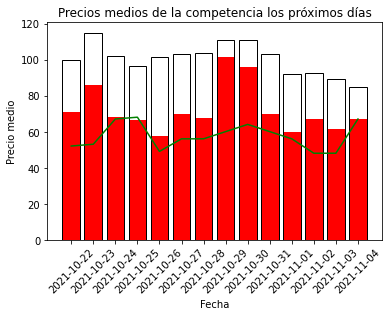

In [38]:
# Representación
x_values1 = df_comp["Date"].unique()
y_values1 = df_comp.groupby(["Date"])["Price"].mean()
x_values2 = df["Date"].unique()
y_values2 = df.groupby(["Date"])["Price"].mean()
x_values3 = df["Date"].unique()
y_values3 = our_df["Rate"]

plt.figure()    #Figura. 
plt.bar(x_values1, y_values1, color = "red")          #El gráfico de la competencia
plt.bar(x_values2, y_values2, color = "blue", fill = False)          #El gráfico global
plt.plot(x_values3, y_values3, color = "green")          #El gráfico nuestro
plt.title('Precios medios de la competencia los próximos días')      #El título
ax = plt.subplot()                   #Axis
ax.set_xticks(x_values3)             #Eje x
ax.set_xticklabels(x_values3, rotation = 45)        #Etiquetas del eje x
ax.set_xlabel('Fecha')  #Nombre del eje x
ax.set_ylabel('Precio medio')  #Nombre del eje y
plt.show()

In [39]:
# Generamos una tabla report
df_report = pd.DataFrame(zip(x_values1, our_rates, y_values1, y_values2, y_values1 - our_rates),
            columns=["Fecha", "NuestroPrecio", "Media Competencia", "Media General", "Diferencia"])
df_report

,Fecha,NuestroPrecio,Media Competencia,Media General,Diferencia
0,2021-10-22,52,70.750000,99.963486,18.750000
1,2021-10-23,53,85.750000,114.933000,32.750000
2,2021-10-24,67,68.333333,101.821503,1.333333
3,2021-10-25,68,66.166667,96.556486,-1.833333
4,2021-10-26,49,57.666667,101.198749,8.666667
5,2021-10-27,56,70.000000,102.917667,14.000000
6,2021-10-28,56,67.500000,103.528067,11.500000
7,2021-10-29,60,101.285714,110.872797,41.285714
8,2021-10-30,64,95.888889,111.046031,31.888889
9,2021-10-31,60,69.500000,102.834462,9.500000


In [40]:
# Generamos unas alertas que nos ayuden a rectificar los precios y adaptarlos a la competencia
# Las alertas se activarán si nuestro precio está por debajo del 70% o por encima del 10% de la competencia.

def alertas(df_report):
    """Genera a partir de un dataframe reporte, una serie de alertas
        para corregir los precios"""
    for index, row in df_report.iterrows():
        if row["NuestroPrecio"] < 0.7*row["Media Competencia"]:
            print("El día {} es necesario subir el precio".format(row["Fecha"]))
        else:
            if row["NuestroPrecio"] > 1.1*row["Media Competencia"]:
                print("El día {} es necesario bajar el precio".format(row["Fecha"]))
alertas(df_report)   

El día 2021-10-23 es necesario subir el precio
El día 2021-10-29 es necesario subir el precio
El día 2021-10-30 es necesario subir el precio



# La variable 'Comments' y su posible interpretación.

La variable 'Comments' contiene el número de comentarios que cosechan los hoteles en el portal booking.com.
Podemos interpretar el número de comentarios que recibe un hotel dado, como su nivel de popularidad entre los usuarios del portal. A mayor número de comentarios - mayor popularidad del hotel. 

Cada comentario lo podemos considerar como una opinión del cliente que haya adquirido su estancia en este hotel y, pues decide dejar un comentario. Además, realmente nos da igual si el comentario es negativo o positivo, ya que tanto si el cliente se quedó satisfecho como no, el cliente pagó su estancia. Esto implica que, de manera muy generalizada, podemos considerar que, por ejemplo, si un hotel dado recibe 1000 comentarios y su precio de estancia por una noche es de 80 euros, muy hipotéticamente podríamos considerar el siguiente flujo financiero: 1000 comentarios x 80 euros = 80000 euros. 

Con lo cual, a mayor número de comentarios -> mayor popularidad entre los clientes -> mayores flujos entrantes para el hotel. Desde el punto de vista del negocio, nos interesaría estudiar esta variable, su relación con otras variables, en general, nos interesa saber qué cualidades poseen los hoteles que cosechan mayores números de comentarios y gozan de mayor popularidad.

En esta práctica, vamos a trabajar sólamente con las variables que tenemos en el dataset, más que nada por el tiempo que supone el scraping y por tener compasión y piedad con el portal booking.com, pero en teoría se podría recoger muchas más variables y hacer un análisis más completo y exhaustivo. Sin embargo, para demostrar la idea nos sobran las variables que ya tenemos.

In [41]:
# Filtramos el dataset de manera que sólo nos aparezcan hoteles 1 vez
df_1 = df.drop_duplicates(subset = ["Name"])
df_1.reset_index(drop=True, inplace=True)
df_1.head()

,Id,Date,Name,Stars,Address,Country,City,Postal_Code,Score,Comments,...,Bar,Terrace,Rooms/Facilities for Disabled,Elevator,Non Smoking Rooms,24 hour Front Desk,Room-service,Airport Shuttle,Parking (fee required),Price
0,0,2021-10-22,Hotel Villa Bandama Golf - Adults Only,4.0,"C/ Montañeta Cha Maria Miranda 10, 35319 Santa...",España,Brígida,35319,"9,1",748.000,...,1,0,0,0,0,0,0,0,0,87.0
1,1,2021-10-22,H10 Estepona Palace,4.0,"Avenida del Carmen, s/n, 29680 Estepona, España",España,Estepona,29680,"8,2",1.986,...,1,0,0,0,0,0,0,0,1,179.0
2,2,2021-10-22,Paradiso Ibiza Art Hotel - Adults Only,4.0,"Avenida Es Calo 64-70 (Illes Balears), 07830 B...",España,Antonio,07830,"8,3",750.000,...,1,0,0,0,1,0,0,0,0,178.0
3,3,2021-10-22,Hotel El Faro Marbella,3.0,"Virgen del Pilar, 11, 29602 Marbella, España",España,Marbella,29602,"8,3",2.020,...,1,0,0,0,0,0,0,1,1,99.0
4,4,2021-10-22,Santos Ibiza - Adults Only,4.0,"Bruc, 3, 07800 Playa d'en Bossa, España",España,Bossa,07800,"8,0",491.000,...,1,0,0,0,0,0,0,0,0,184.0


Para poder trabajar con la variable 'Comments', tenemos que pasar los valores al formato adecuado, ya que en el portal el número de comentarios contiene el separador de miles, lo que hace que, por ejemplo, 750 comentarios se interpretan como 750.00, lo que es correcto, mientras que los 1986 comentarios, que en el portal al contener el punto separador de miles(1.986) se interpretan tal cual, 1.986(1 comentario con 986 milésimas), lo que es incorrecto. Con lo cual, tenemos que pasar los valores mayores de 1000 comentarios al formato adecuado.

In [42]:
# Creamos un vector con valores false/true, de manera que aquellos 
# valores que tienen parte decimal sean 'true', para luego simplemente
# multiplicarlos por 1000, y los valores que no tienen parte 
# decimal(valores inferiores a 1000 comentarios en booking.com) sean 'false'
vec=[]
for i in range(0,len(df_1.Comments)):
    vec.append(int(df_1.Comments.astype(str).str.split('.')[i][1])>0)

In [43]:
# Multiplicamos valores con parte decimal por 1000 y dejamos los demás
# como están
df_1.loc[:,'Comments']=np.where(vec, df_1.Comments*1000, df_1.Comments)

In [44]:
df_1.head()

,Id,Date,Name,Stars,Address,Country,City,Postal_Code,Score,Comments,...,Bar,Terrace,Rooms/Facilities for Disabled,Elevator,Non Smoking Rooms,24 hour Front Desk,Room-service,Airport Shuttle,Parking (fee required),Price
0,0,2021-10-22,Hotel Villa Bandama Golf - Adults Only,4.0,"C/ Montañeta Cha Maria Miranda 10, 35319 Santa...",España,Brígida,35319,"9,1",748.0,...,1,0,0,0,0,0,0,0,0,87.0
1,1,2021-10-22,H10 Estepona Palace,4.0,"Avenida del Carmen, s/n, 29680 Estepona, España",España,Estepona,29680,"8,2",1986.0,...,1,0,0,0,0,0,0,0,1,179.0
2,2,2021-10-22,Paradiso Ibiza Art Hotel - Adults Only,4.0,"Avenida Es Calo 64-70 (Illes Balears), 07830 B...",España,Antonio,07830,"8,3",750.0,...,1,0,0,0,1,0,0,0,0,178.0
3,3,2021-10-22,Hotel El Faro Marbella,3.0,"Virgen del Pilar, 11, 29602 Marbella, España",España,Marbella,29602,"8,3",2020.0,...,1,0,0,0,0,0,0,1,1,99.0
4,4,2021-10-22,Santos Ibiza - Adults Only,4.0,"Bruc, 3, 07800 Playa d'en Bossa, España",España,Bossa,07800,"8,0",491.0,...,1,0,0,0,0,0,0,0,0,184.0


 Vemos que valores superiores a 1000 han tomado el formato adecuado, con lo cual ya podemos proceder con el análisis.

Empezamos con simplemente ver las distribuciones.


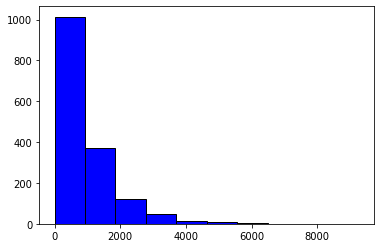

In [45]:
plt.hist(df_1['Comments'], color = 'blue', edgecolor = 'black', fill =True)
plt.show()

In [46]:
# Hallamos el mínimo
df_1.Comments.min()

1.0

In [47]:
# Hallamos el máximo
df_1.Comments.max()

9267.999999999998

In [48]:
# Hallamos la media
df_1.Comments.mean()

938.4499054820416

Vemos que hay más comentarios hasta 1000, mientras que el mínimo es sólo de 1 comentario y el máximo son 9268 comentarios. La media nos servirá de umbral, el número de comentarios inferior a la media los vamos a considerar como pocos(low), y los que superan a la media, los consideraremos como muchos(high). Vamos a crear una variable binaria, 'Comments_hl'(de Comments_high/low), que contendrá 1 para los comentarios que superan a la media(high) y 0 para comentarios inferiores a la media(low). Está variable la vamos a necesitar para generar las reglas de asociación.

In [49]:
# Creamos una variable binaria, 1 para los comentarios que superan a la
# media, y 0 para los que no
df_1['Comments_hl'] = np.where(df_1.Comments>df_1.Comments.mean(), 1,0)

In [50]:
df_1.Comments_hl.isna().any()

False

Representamos las frecuencias de la variable 'Stars'.

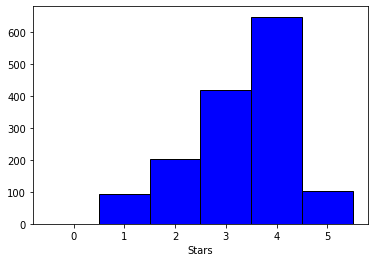

In [51]:
# Representamos histograma de la variable 'Stars'
plt.hist(df_1['Stars'], bins=np.arange(7)-0.5, color = 'blue', edgecolor = 'black')
plt.xlabel('Stars')
plt.show()

Vemos que hay más hoteles de 4 estrellas y muy pocos(que no llegan a los 100) de 1 y de 5 estrellas.

Ahora sería interesante representar el número de estrellas en función de comentarios recebidos.


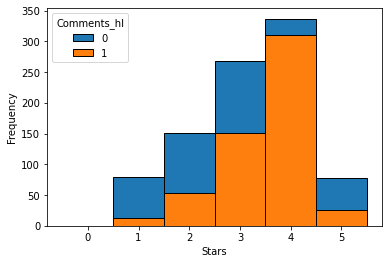

In [52]:
# Representamos las estrellas en función de comentarios
df_1.pivot(columns='Comments_hl', values='Stars').plot.hist(bins=np.arange(7)-0.5, edgecolor='black')
plt.xlabel('Stars')
plt.show()

Está claro que los hoteles de 4 estrellas cosechan el mayor número de comentarios.

La siguiente variable que vamos a ver es el precio.


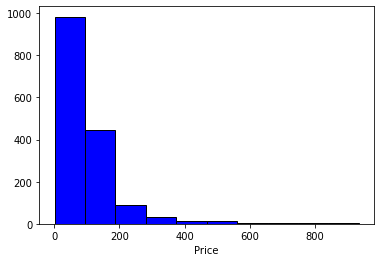

In [53]:
# Representamos las frecuencias de los precios
plt.hist(df_1['Price'], color = 'blue', edgecolor = 'black')
plt.xlabel('Price')
plt.show()

Vemos que prevalecen los precios hasta 100 euros. Vamos a aumentar un poco el gráfico exluyendo los precios inferiores a 300 euros.

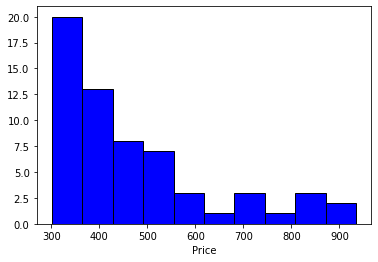

In [54]:
# Excluímos los precios inferiores a 300 euros
plt.hist(df_1.Price[df_1.Price>300], color = 'blue', edgecolor = 'black')
plt.xlabel('Price')
plt.show()

Nos convendría discretizar la variable 'Price' partiéndola en intervalos.

In [55]:
# Partimos en intervalos la variable Price
df_1['Price_cat'] = pd.cut(df_1.Price, [1,100,200,300,400,500,600,700,800,900,1000])

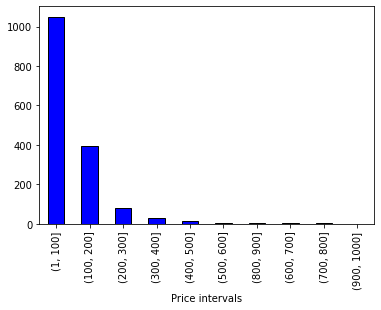

In [56]:
# Representamos los intervalos del precio
df_1.Price_cat.value_counts().plot.bar(color = 'blue', edgecolor = 'black')
plt.xlabel('Price intervals')
plt.show()

Hay más precios hasta 100 euros. Vamos a representar los precios en función de los comentarios.



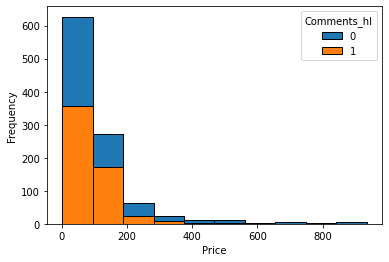

In [57]:
# Representamos los precios en función de los comentarios
df_1.pivot(columns='Comments_hl', values='Price').plot.hist(edgecolor='black')
plt.xlabel('Price')
plt.show()

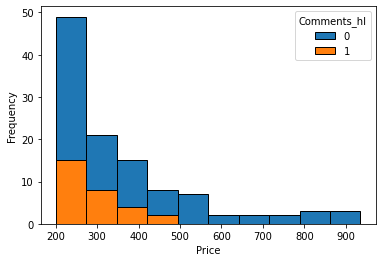

In [58]:
# Representamos los precios en función de comentarios excluyendo
# los precios inferiores a 200 euros
df_1[df_1.Price>200].pivot(columns='Comments_hl', values='Price').plot.hist(edgecolor='black')
plt.xlabel('Price')
plt.show()

In [59]:
# Calculamos cuántos comentarios superiores a la media hay
# en cado intervalos del precios
df_1.Price_cat[df_1.Comments_hl==1].value_counts()

(1, 100]       385
(100, 200]     151
(200, 300]      22
(300, 400]       5
(400, 500]       2
(900, 1000]      0
(800, 900]       0
(700, 800]       0
(600, 700]       0
(500, 600]       0
Name: Price_cat, dtype: int64

In [60]:
# Calculamos el valor relativo de los comentarios superiores a la
# media en cada intervalo del precio
for i,n in enumerate(df_1.Price_cat.value_counts()):
    #print(n)
    print(df_1.Price_cat[df_1.Comments_hl==1].value_counts().index[i],list(df_1.Price_cat[df_1.Comments_hl==1].value_counts())[i]/n)
    


(1, 100] 0.36666666666666664
(100, 200] 0.3813131313131313
(200, 300] 0.275
(300, 400] 0.17857142857142858
(400, 500] 0.13333333333333333
(900, 1000] 0.0
(800, 900] 0.0
(700, 800] 0.0
(600, 700] 0.0
(500, 600] 0.0


Vemos que el intervalo (100, 200] contiene el mayor número de comentarios superiores a la media.

Vamos a representar las variables 'Comments' y 'Price' una contra otra para ver si existe alguna relación de dependencia.


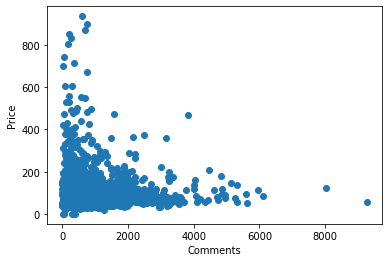

In [61]:
# Representamos los somentarios contra los precios
plt.scatter(df_1.Comments, df_1.Price)
plt.xlabel('Comments')
plt.ylabel('Price')
plt.show()

No se aprecia relación de dependencia clara entre el precio y el número de comentarios.

# Reglas de asociación.


También podemos aplicar el algoritmo de las reglas de asociación al conjunto de atributos, para descubrir algunos patrones que ocurren en común y que tienen alguna consecuencia. En este caso, nos interesaría descubrir algunas causas(reglas) que hacen que el hotel goce de popularidad(un número de comentarios alto), nos interesa descubrir qué conjunto de atributos(por ejemplo:['Airport Shuttle (free)','BBQ facilities', 'Free WiFi Internet Access Included', '4_Stars']) tienen los hoteles que están altamente populares(tienen un número de comentarios alto) en el portal booking.com. 

Este conjunto de atributos, ['Airport Shuttle (free)','BBQ facilities', 'Free WiFi Internet Access Included', '4_Stars'], se denomina 'antecedente'(X), y el número alto de comentarios(Y), es el consecuente. Con lo cual, la definición formal de una regla sería la implicación X=>Y, que siguiendo con el ejemplo de nuestro caso sería: ['Airport Shuttle (free)','BBQ facilities', 'Free WiFi Internet Access Included', '4_Stars'] => alto nº de comentarios. O sea, nos interesa descubrir conjuntos de antecedentes que implican alto nº de comentarios. 

In [62]:
# Para poder aplicar el algoritmo de reglas de asociación, tenemos que pasarle
# el dataset en forma binaria(1 o 0). Con lo cual, añadimos a los atributos
# binarios que ya teníamos, algunos más.
df_1['nan'] = np.where(df_1.Stars=='nan', 1,0)
df_1['1_Star'] = np.where(df_1.Stars==1, 1,0)
df_1['2_Stars'] = np.where(df_1.Stars==2, 1,0)
df_1['3_Stars'] = np.where(df_1.Stars==3, 1,0)
df_1['4_Stars'] = np.where(df_1.Stars==4, 1,0)
df_1['5_Stars'] = np.where(df_1.Stars==5, 1,0)
df_1['Price_high'] = np.where(df_1.Price>df_1.Price.mean(), 1,0)
df_1['Price_low'] = np.where(df_1.Price<df_1.Price.mean(), 1,0)

In [63]:
# El proceso de generación de las reglas de asociación consiste de
# 2 etapas: primero se genera un dataset de artículos frecuentes,
# 'frequent_itemsets', el umbral de frecuencia 'min_support' lo
# establecemos nosotros, lo que quiere decir que quremos generar
# un subset, cuyos elementos(subconjuntos de atributos) ocurren
# simultáneamente con una frecuencia mínima que establezcamos,
# por ejemplo, en un 10% de registros(transacciones), y luego
# pasamos el 'frequent_itemsets' al algoritmo 'association_rules'

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules


# Generamos el dataset de artículos frecuentes
frequent_itemsets = apriori(df_1.loc[:, ['Airport Shuttle (free)',
       'BBQ facilities', 'Free WiFi Internet Access Included', 'Wireless Lan',
       'Daily maid service', 'Swimming pool', 'Pets allowed', 'Free Parking',
       'Spa & Wellness Centre', 'Fitness Room', 'Private Beach Area',
       'Heating', 'Family Rooms', 'Coffee/Tea maker', 'Restaurant',
       'Beach front', 'Garden', 'Bar', 'Terrace',
       'Rooms/Facilities for Disabled', 'Elevator', 'Non Smoking Rooms',
       '24 hour Front Desk', 'Room-service', 'Airport Shuttle',
       'Parking (fee required)', 'nan', '1_Star', '2_Stars', '3_Stars', 
        '4_Stars', '5_Stars','Price_high','Price_low','Comments_hl']], min_support=0.1, use_colnames=True)

In [64]:
# Generamos las reglas de asociación, usando el soporte('support') como métrica
# con un umbral mínimo del 10%. Lo que quiere decir que queremos generar las
# reglas que aparecen como mínimo en un 10% de transacciones.
rules = association_rules(frequent_itemsets, metric="support", min_threshold=0.1)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Free WiFi Internet Access Included),(Swimming pool),0.694392,0.582231,0.428481,0.617060,1.059820,0.024185,1.090952
1,(Swimming pool),(Free WiFi Internet Access Included),0.582231,0.694392,0.428481,0.735931,1.059820,0.024185,1.157303
2,(Pets allowed),(Free WiFi Internet Access Included),0.170132,0.694392,0.124764,0.733333,1.056080,0.006625,1.146030
3,(Free WiFi Internet Access Included),(Pets allowed),0.694392,0.170132,0.124764,0.179673,1.056080,0.006625,1.011631
4,(Free Parking),(Free WiFi Internet Access Included),0.247007,0.694392,0.184625,0.747449,1.076408,0.013105,1.210084


In [65]:
# Ahora, filtramos las reglas obtenidas de manera que sólo queremos
# aquellas reglas, cuyo consecuente es 'Comments_hl'(el nº de comentarios alto)
# y cuya confianza es mayor del 50%
lft = rules[(rules.consequents=={'Comments_hl'})&
            (rules['confidence']>0.5)].sort_values('confidence', ascending=False)
lft.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
2286,"(Price_low, Parking (fee required), Swimming p...",(Comments_hl),0.148078,0.356018,0.102079,0.689362,1.936313,0.049361,2.073094
3347,"(Parking (fee required), 4_Stars, Bar, Swimmin...",(Comments_hl),0.155640,0.356018,0.107120,0.688259,1.933216,0.051710,2.065762
2272,"(4_Stars, Parking (fee required), Swimming pool)",(Comments_hl),0.159420,0.356018,0.109011,0.683794,1.920676,0.052254,2.036594
2524,"(4_Stars, Bar, Parking (fee required))",(Comments_hl),0.185255,0.356018,0.126654,0.683673,1.920336,0.060700,2.035815
3137,"(Parking (fee required), 4_Stars, Free WiFi In...",(Comments_hl),0.148708,0.356018,0.100189,0.673729,1.892403,0.047246,1.973764
1021,"(4_Stars, Parking (fee required))",(Comments_hl),0.196597,0.356018,0.131065,0.666667,1.872566,0.061073,1.931947
1838,"(4_Stars, Free WiFi Internet Access Included, ...",(Comments_hl),0.158160,0.356018,0.103340,0.653386,1.835264,0.047032,1.857926
2188,"(Bar, Swimming pool, Parking (fee required))",(Comments_hl),0.237555,0.356018,0.150599,0.633952,1.780677,0.066025,1.759285
2928,"(Parking (fee required), Free WiFi Internet Ac...",(Comments_hl),0.188406,0.356018,0.117202,0.622074,1.747311,0.050126,1.703989
650,"(Parking (fee required), Swimming pool)",(Comments_hl),0.248267,0.356018,0.154379,0.621827,1.746620,0.065992,1.702880


In [66]:
# Mostramos las 7 primeras reglas con su correspondiente soporte,
# confianza y lift
for index, row in lft.iloc[0:7,[0,4,5,6]].iterrows():
    print(str(row.antecedents)+' support:'+str(round(row.support,2))+
          '; confidence:'+str(round(row.confidence,2))+'; lift: '+str(round(row.lift,2)))
    print()

frozenset({'Price_low', 'Parking (fee required)', 'Swimming pool'}) support:0.1; confidence:0.69; lift: 1.94

frozenset({'Parking (fee required)', '4_Stars', 'Bar', 'Swimming pool'}) support:0.11; confidence:0.69; lift: 1.93

frozenset({'4_Stars', 'Parking (fee required)', 'Swimming pool'}) support:0.11; confidence:0.68; lift: 1.92

frozenset({'4_Stars', 'Bar', 'Parking (fee required)'}) support:0.13; confidence:0.68; lift: 1.92

frozenset({'Parking (fee required)', '4_Stars', 'Free WiFi Internet Access Included', 'Bar'}) support:0.1; confidence:0.67; lift: 1.89

frozenset({'4_Stars', 'Parking (fee required)'}) support:0.13; confidence:0.67; lift: 1.87

frozenset({'4_Stars', 'Free WiFi Internet Access Included', 'Parking (fee required)'}) support:0.1; confidence:0.65; lift: 1.84



La interpretación de las reglas de asociación generadas podría ser la siguiente.

La primera regla nos dice que en el dataset hay un 10% de transacciones(registros), support:0.1, con los atributos ['Swimming pool'(piscina), 'Parking(fee required)' y Price_low(precio por debajo de la media)] como antecedente, y de estos 10%, hay un 69% que tienen 'Comments_hl'(el nº alto de comentarios) como consecuente. Es decir, por ejemplo de los 100 transacciones(registros), los 10 tienen este conjunto de atributos, y de estos 10, los casi 7 implican un nº de comentarios alto. Con lo cual, podríamos decir que si un hotel posee estos atributos, con una probabilidad de casi 70%, este hotel tendrá un nº de comentarios elevado.

El indicador 'lift' nos indica la tasa de soporte observada sobre la esperada si X e Y fueran independientes. Un lift < 1 quiere decir que la tasa de soporte observada aparece menos veces que la esperada, mientras que un lift > 1 nos dice que la tasa de soporte observada aparece más veces de la esperada. En nuestro caso, lift(X=>Y)=1.94 quiere decir que es más probable que los sucesos X e Y ocurran juntos, que por separado. En otras palabras, un lift > 1 nos dice que es más probable que el conjunto de atributos ['Swimming pool'(piscina), 'Parking(fee required)' y Price_low(precio por debajo de la media)] implique un nº de comentarios alto, que no. Con lo cual, un lift=1.94 indica que esta regla es bastante fuerte.

La segunda regla tiene los siguientes atributos como antecedente:['Swimming pool', '4_Stars', 'Bar', 'Parking (fee required)']. Este conjunto aparece en un 11% de transacciones(registros), support=0.11. De este 11% de transacciones, en un 69% implica el nº de comentarios alto, confidence=0.69. Un lift=1.93 nos indica que esta regla también es bastante fuerte. Con lo cual, podríamos afirmar que si un hotel tiene piscina, bar, parking y es de 4 estrellas, con una probabilidad de casi 70% este hotel cosecharía un nº de comentarios alto.

Todas las demás reglas se interpretan de la misma manera, sólo que cambian los conjuntos de atributos, y los indicadores 'support', 'confidence' y 'lift' varían ligeramente.
